In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def interpretData(data_list, thickness_info = True, thickness_list = None, concentration_info = True, concentration = None):
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieve thickness data
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > 2].iloc[0])

    data_name = namestr(data_list[0], globals())
    if concentration_info == True:
        conc = concentration
    else:
        conc = data_name.split('_')[2]
        if len(conc) > 2:
            conc = conc[:-2]
    if data_name.split('_')[1] == 'heating':
        heating = True
    else:
        heating = False
    
    mechanicalProperties = [float(conc), heating]
    
    #SET UP STRESS STRAIN CURVE
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    plt.figure(figsize=(8, 6))
    
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())

        trial = data_name.split('_')[2:]
        if len(trial[0]) > 2:
            trial[0] = trial[0][:-2]
        trial = '_'.join(trial)
        print(trial)

        
        data = data_list[i][data_list[i]['Ch:Load (N)'] >1]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()     #find index of fracture point
        fracture_index += 1
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        plt.scatter(data['strain'], data['stress (bar)'], color='lightgrey', label=data_name)

    #SPLINE MODEL
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        #print(gam.summary())
        plt.plot(data[['strain']], predictions, color='black',label='Spline Model')

    #DERIVATIVE
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

    #SEGMENT REGIONS
        #elastic region
        data['2nd derivative'].idxmin()            
        breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(changepoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]
        
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(breakpoint1.reshape(1,-1))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        #plateau & densification region
        regions = data[data['strain'] >= breakpoint1]
        pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=4)
        pw_results = pw_fit.get_results()
        eval = None
        if pw_results['estimates'] != None:
            breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
            breakpoint3 = pw_results['estimates']['breakpoint4']['estimate']
            plateauRegion = regions[regions['strain'] <= breakpoint2]
            densificationRegion = regions[regions['strain'] >= breakpoint3]

        #plateau region
            modelPlateau = LinearRegression()
            modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
            slopePlateau = modelPlateau.coef_[0]
            interceptPlateau = modelPlateau.intercept_

        #densification region
            modelDensification = LinearRegression()
            modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
            slopeDensification = modelDensification.coef_[0]
            interceptDensification = modelDensification.intercept_

        #changepoint calculations
            changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
            xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
            xDensification = data[changepoint <= data['strain']]
            if len(xDensification) > 0 and len(xPlateau) > 0:
                predPlateau = modelPlateau.predict(xPlateau[['strain']])
                predDensification = modelDensification.predict(xDensification[['strain']])

        #FITTING EVALUATION
                plateauModel = LinearGAM(s(0))
                plateauModel.fit(xPlateau[['strain']], xPlateau['stress (bar)'])
                plateauSpline = plateauModel.predict(xPlateau[['strain']])

                correlation_coefficient = np.corrcoef(plateauSpline, predPlateau)[0, 1]

                print("Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate:", correlation_coefficient)
                print("Elastic Modulus:", elasticModulus)
                print("Plateau Slope:", slopePlateau)
                
                rangeStart = yieldStrength - 3     #arbitrary range
                rangeEnd = yieldStrength + 3
                if rangeStart <= modelPlateau.predict(breakpoint1.reshape(1, -1)) <= rangeEnd and slopePlateau <= elasticModulus*1.25 and correlation_coefficient <= 0.98:
                    eval = True
                else:
                    eval = False

    #MATERIAL PROPERTIES
                dict = {'Trial': trial,
                        "Thickness": thickness[i],
                        "Elastic Modulus":elasticModulus, 
                        "Yield Strength":yieldStrength, 
                        "Changepoint":changepoint, 
                        "Slope Plateau":slopePlateau, 
                        "Slope Densification":slopeDensification,
                        "Good Fit":eval}
                mechanicalProperties.append(dict)

    #FINAL GRAPH
                plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region')
                plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region")
                plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region")
        
        plt.title(data_name)
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

        print("Good Fit:", eval)

    #DERIVATIVE PLOT
        plt.plot(data[['strain']], data['2nd derivative'], label='2nd Derivative')
        plt.title('2nd Derivative')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

    return mechanicalProperties

def extract(materialProperties):    
    for i in range(2,len(materialProperties)):
        thickness.append(materialProperties[i]['Thickness'])
        conc.append(materialProperties[0])
        heating.append(materialProperties[1])
        trial_number.append(materialProperties[i]['Trial'])
            
        elasticModulus.append(materialProperties[i]['Elastic Modulus'])
        yieldStrength.append(materialProperties[i]['Yield Strength'])
        slopePlateau.append(materialProperties[i]['Slope Plateau'])
        slopeDensification.append(materialProperties[i]['Slope Densification'])
        changepoint.append(materialProperties[i]['Changepoint'])
        fit.append(materialProperties[i]["Good Fit"])

def extractAverage(materialProperties):
    thickness = []
    
    elasticModulus = []
    yieldStrength = []
    slopePlateau = []
    slopeDensification = []
    changepoint = []

    elasticModulusBAD = []
    yieldStrengthBAD = []
    slopePlateauBAD = []
    slopeDensificationBAD = []
    changepointBAD = []
    
    for i in range(2,len(materialProperties)):
        thickness = materialProperties[i]['Thickness']
        if materialProperties[i]["Good Fit"] == True:
            elasticModulus.append(materialProperties[i]['Elastic Modulus'])
            yieldStrength.append(materialProperties[i]['Yield Strength'])
            slopePlateau.append(materialProperties[i]['Slope Plateau'])
            slopeDensification.append(materialProperties[i]['Slope Densification'])
            changepoint.append(materialProperties[i]['Changepoint'])
        else:
            elasticModulusBAD.append(materialProperties[i]['Elastic Modulus'])
            yieldStrengthBAD.append(materialProperties[i]['Yield Strength'])
            slopePlateauBAD.append(materialProperties[i]['Slope Plateau'])
            slopeDensificationBAD.append(materialProperties[i]['Slope Densification'])
            changepointBAD.append(materialProperties[i]['Changepoint'])

    if len(elasticModulus) == 0:
        elasticModulus = elasticModulusBAD
        yieldStrength = yieldStrengthBAD
        slopePlateau = slopePlateauBAD
        slopeDensification = slopeDensificationBAD
        changepoint = changepointBAD
        eval = 'BAD'
    elif len(elasticModulus) >= len(materialProperties)-2 and len(elasticModulus) > 1:
        eval = 'GOOD'
    else:
        elasticModulus.extend(elasticModulusBAD)
        yieldStrength.extend(yieldStrengthBAD)
        slopePlateau.extend(slopePlateauBAD)
        slopeDensification.extend(slopeDensificationBAD)
        changepoint.extend(changepointBAD)
        eval = 'OK'
    
    conc.append(materialProperties[0])
    heating.append(materialProperties[1])
    thickness_mean.append(np.mean(thickness))
    thickness_stdev.append(np.std(thickness))
    
    
    E_mean.append(np.mean(elasticModulus))
    E_stdev.append(np.std(elasticModulus, ddof=1))
    YS_mean.append(np.mean(yieldStrength))
    YS_stdev.append(np.std(yieldStrength, ddof=1))
    SP_mean.append(np.mean(slopePlateau))
    SP_stdev.append(np.std(slopePlateau, ddof=1))
    SD_mean.append(np.mean(slopeDensification))
    SD_stdev.append(np.std(slopeDensification, ddof=1)) 
    C_mean.append(np.mean(changepoint))
    C_stdev.append(np.std(changepoint, ddof=1))
    fit.append(eval)

10_4_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9854888889012555
Elastic Modulus: 32.93346058301236
Plateau Slope: 581.4854869356495


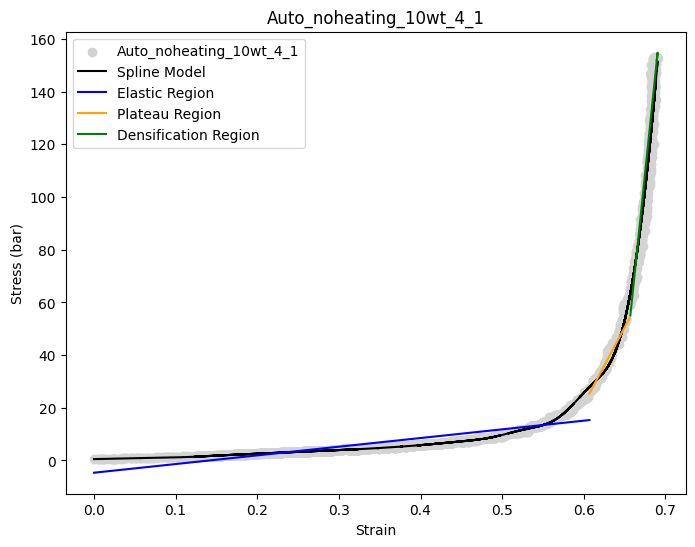

Good Fit: False


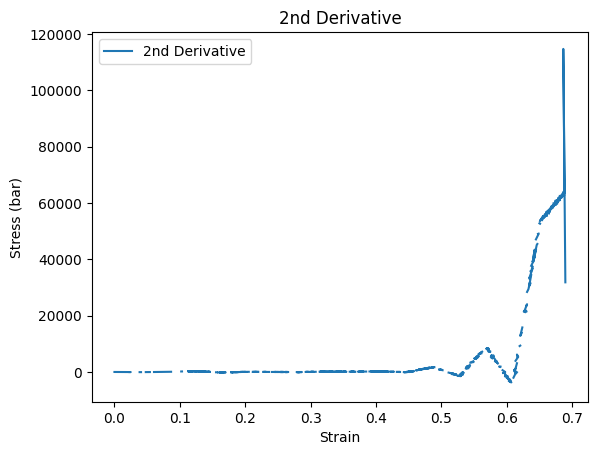

10_4_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8381701338067798
Elastic Modulus: 9.774049695755956
Plateau Slope: 19.013281824082732


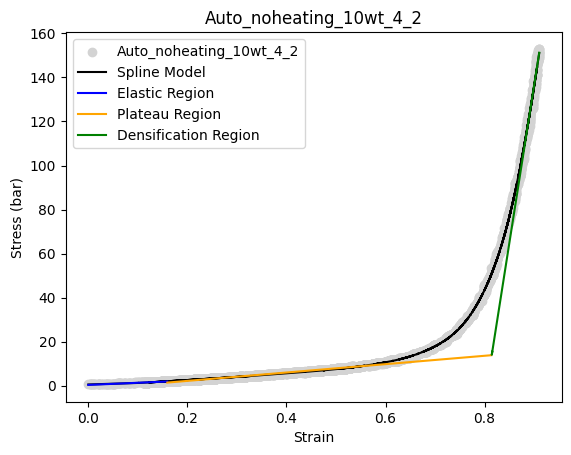

Good Fit: False


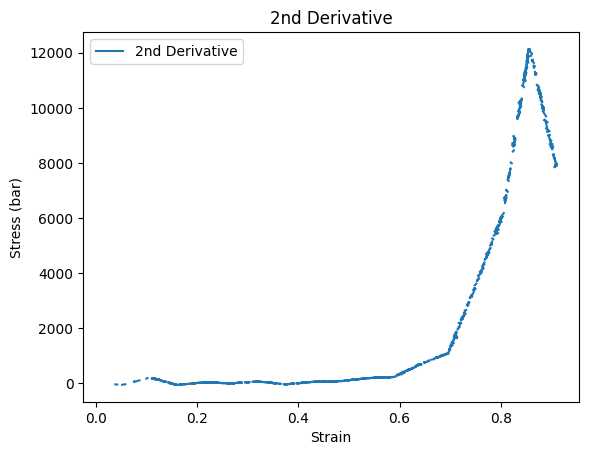

10_4_3


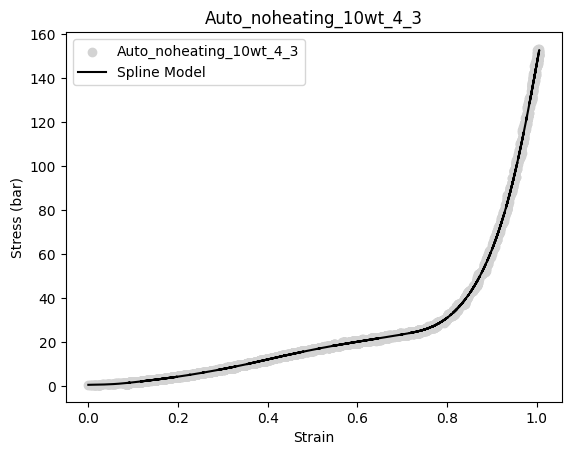

Good Fit: None


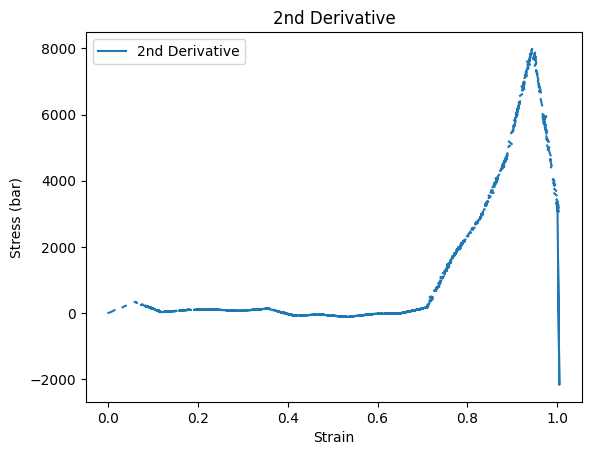

12_4_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8725420316617889
Elastic Modulus: 37.68824149429307
Plateau Slope: 19.52588607369305


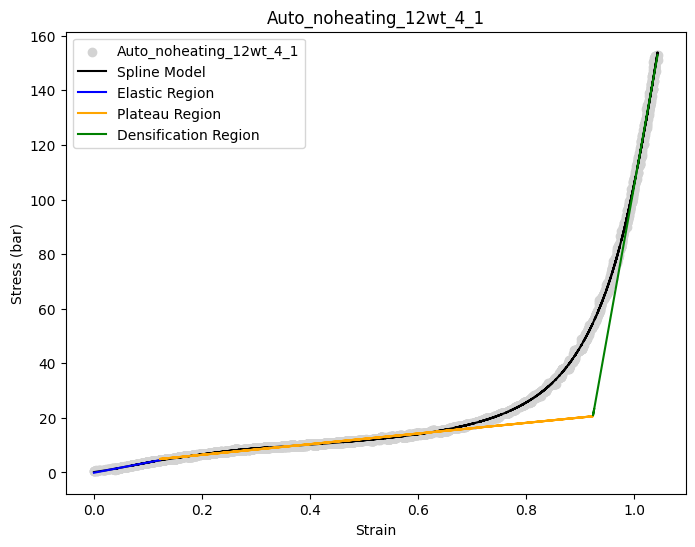

Good Fit: True


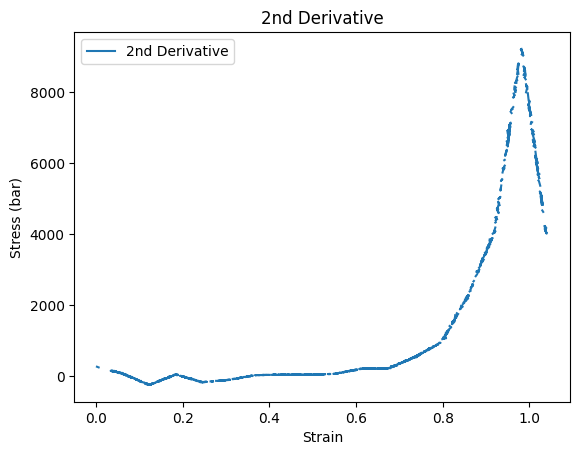

12_4_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8632135133862493
Elastic Modulus: 28.62153749308103
Plateau Slope: 21.7651675680202


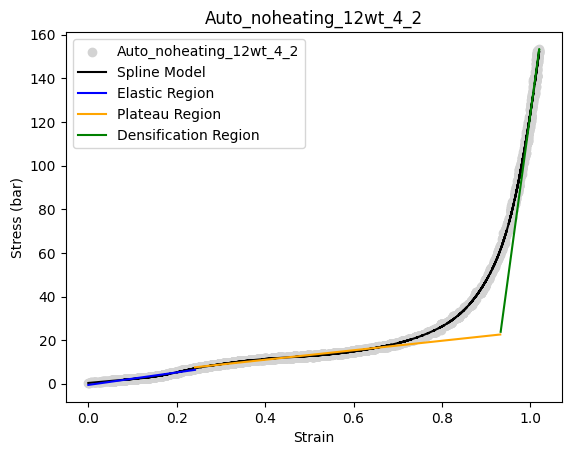

Good Fit: True


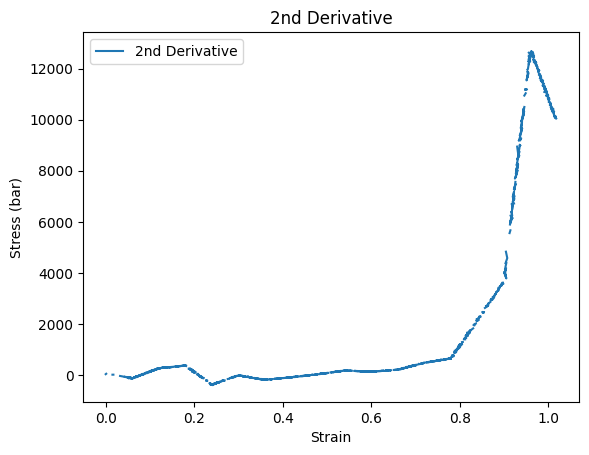

12_4_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8747391177916675
Elastic Modulus: 38.197206760594085
Plateau Slope: 23.465412776276903


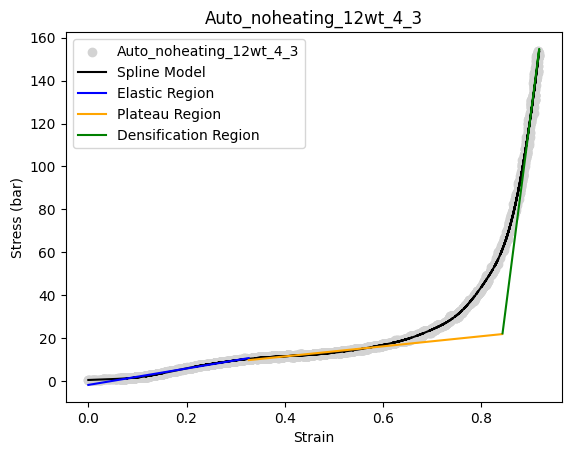

Good Fit: True


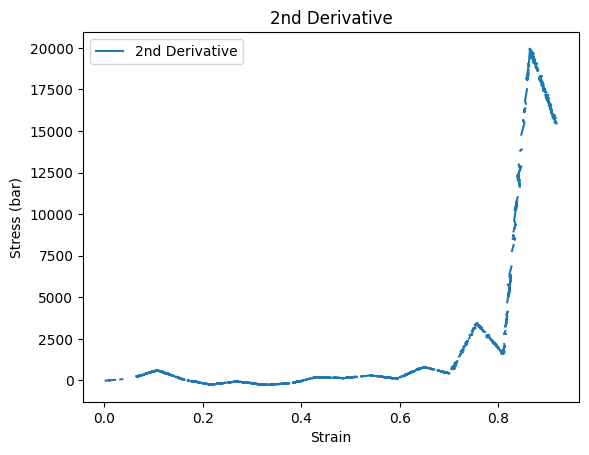

12_4_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.85994331595593
Elastic Modulus: 44.3195699017501
Plateau Slope: 23.40369738248941


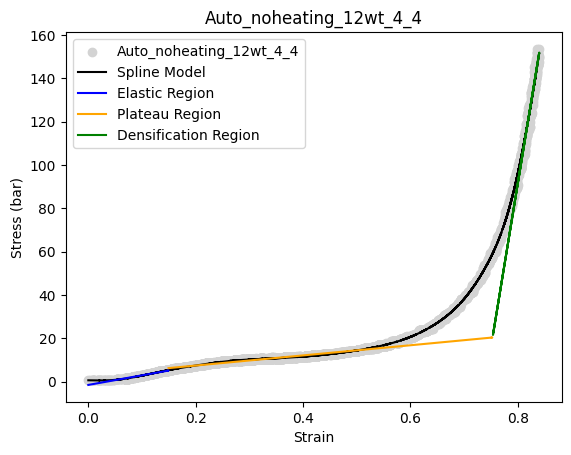

Good Fit: True


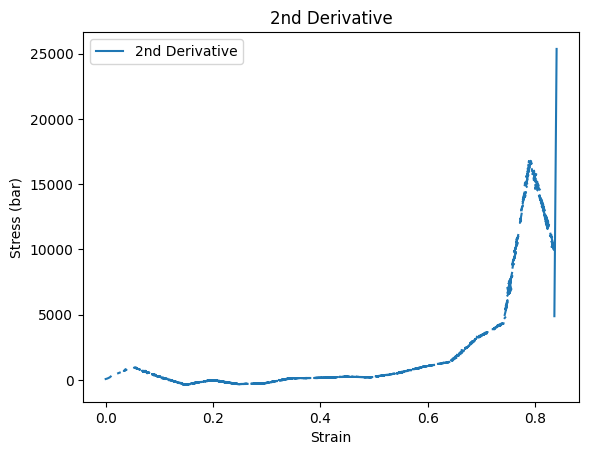

12_4_5
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8871141273005584
Elastic Modulus: 48.01442404500027
Plateau Slope: 26.439765797305217


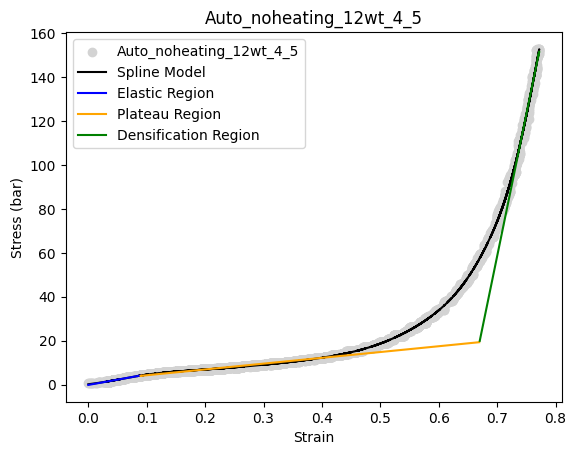

Good Fit: True


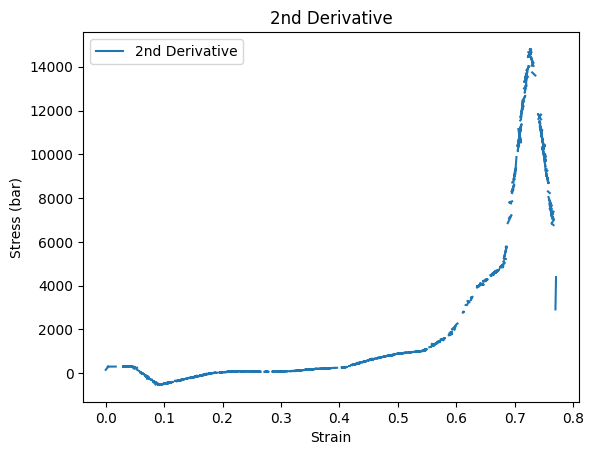

15_4_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9510214869981278
Elastic Modulus: 122.24632452504612
Plateau Slope: 55.857568812141594


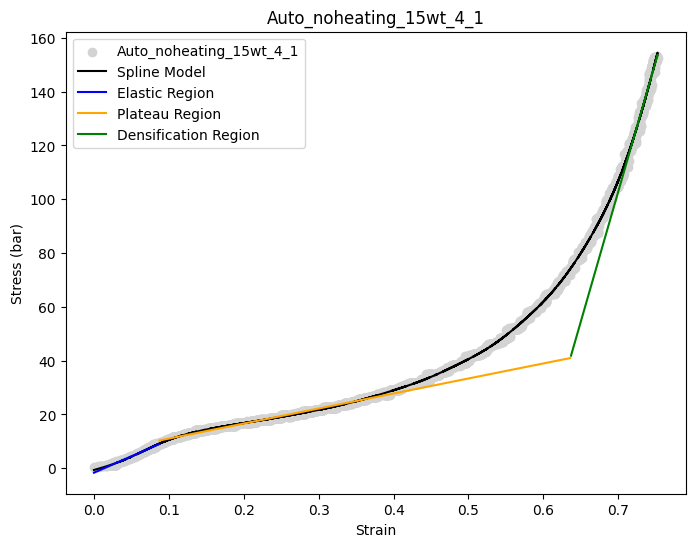

Good Fit: True


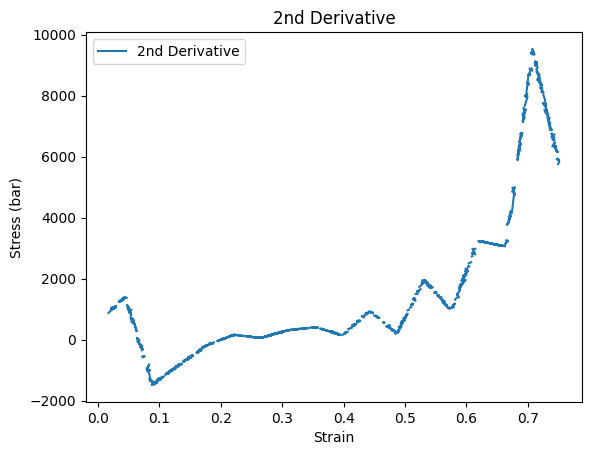

15_4_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9528451751576703
Elastic Modulus: 122.66084675279332
Plateau Slope: 55.314307930348384


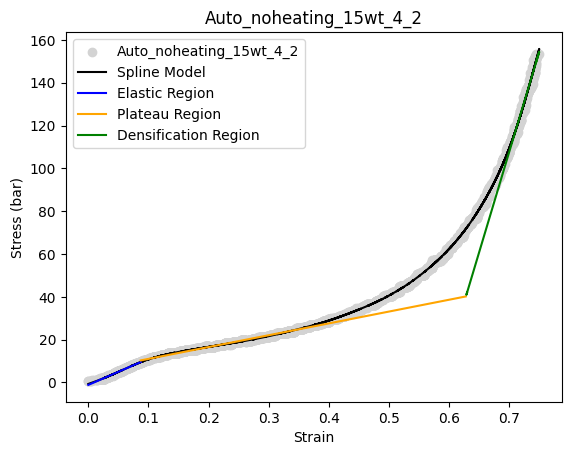

Good Fit: True


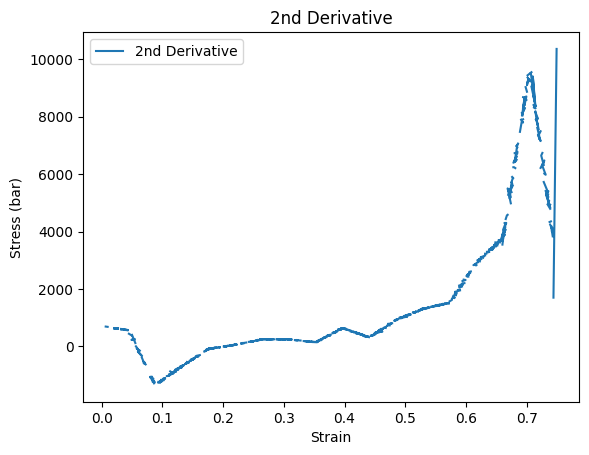

15_4_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9496944597576417
Elastic Modulus: 116.49842567823778
Plateau Slope: 52.74498550810999


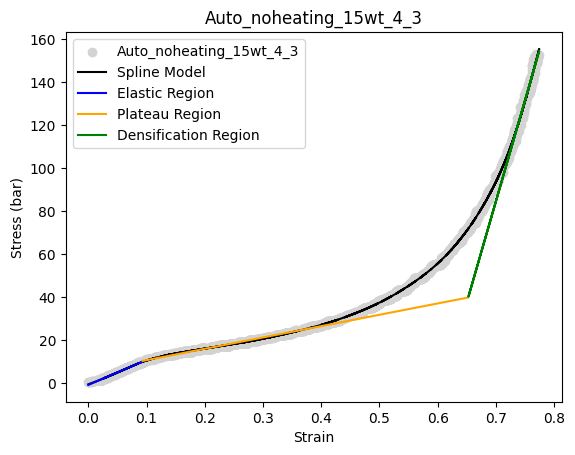

Good Fit: True


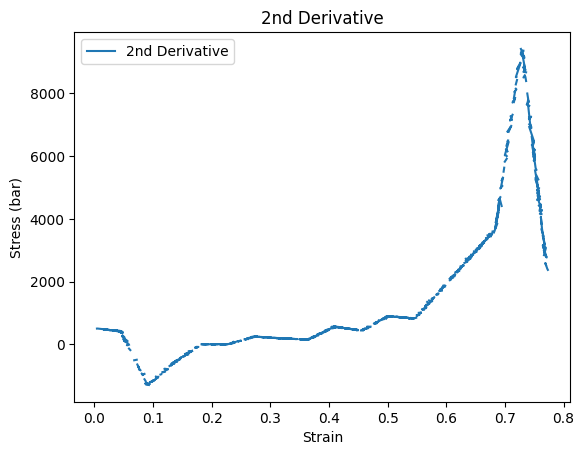

15_4_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9499726687470169
Elastic Modulus: 117.02087681356167
Plateau Slope: 51.885672181681805


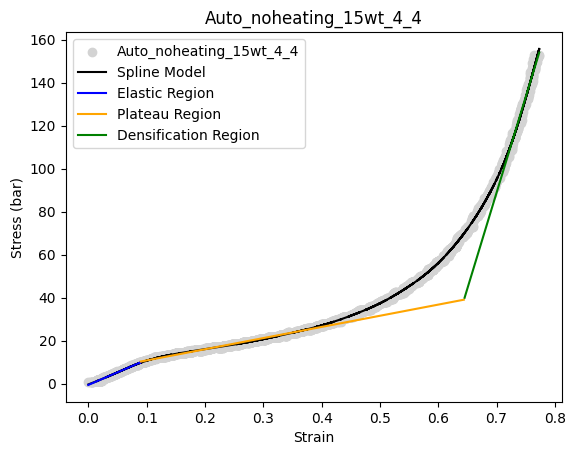

Good Fit: True


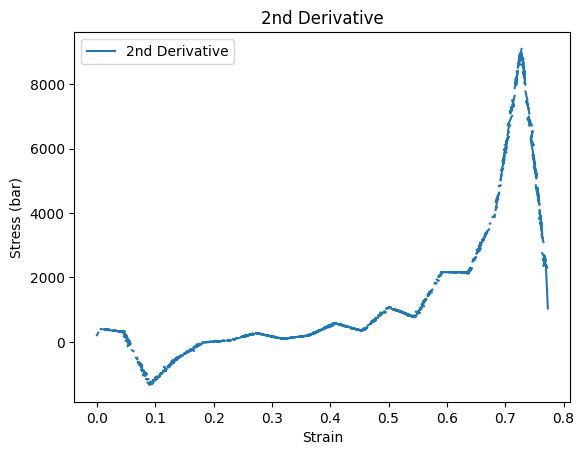

17_4_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9714598161727125
Elastic Modulus: 180.68923031686845
Plateau Slope: 78.2069213225373


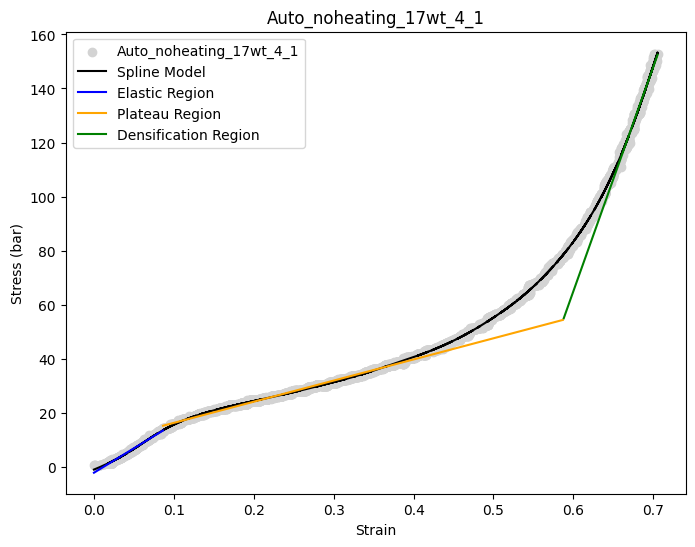

Good Fit: True


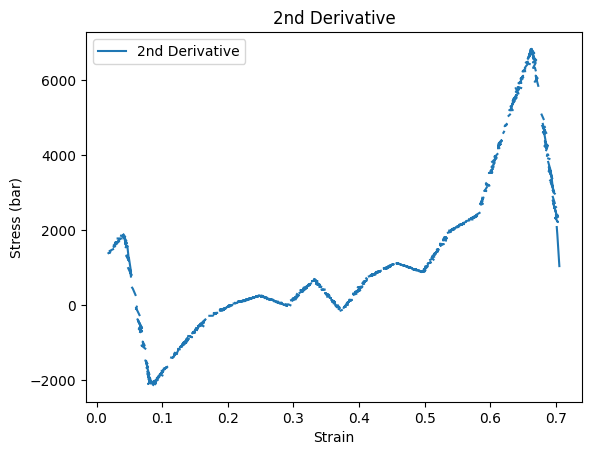

17_4_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9685540424051977
Elastic Modulus: 175.06301844635186
Plateau Slope: 73.9065350486947


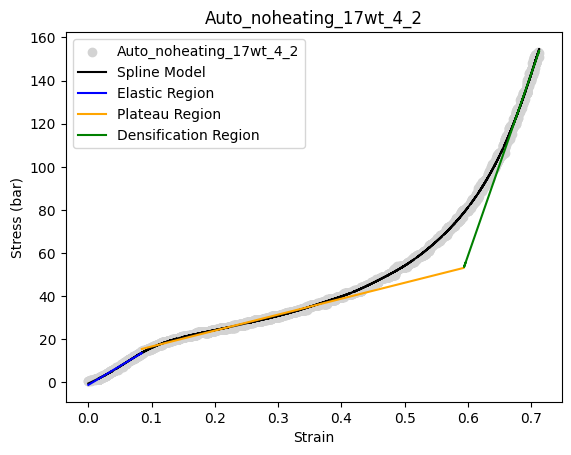

Good Fit: True


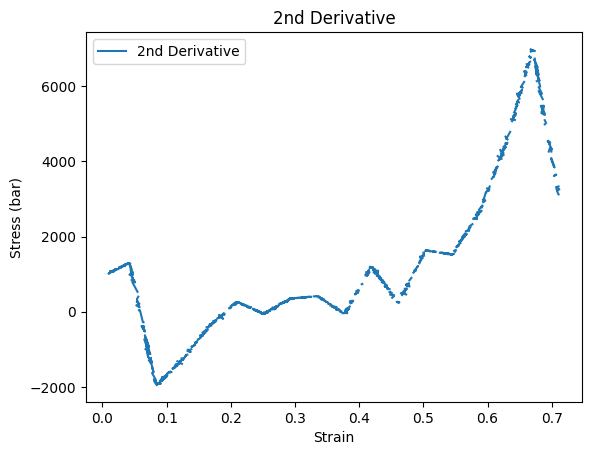

17_4_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9674075716458405
Elastic Modulus: 174.354164897772
Plateau Slope: 76.30012876677193


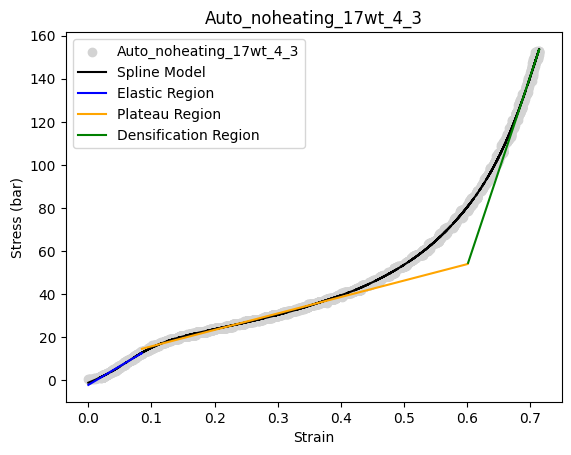

Good Fit: True


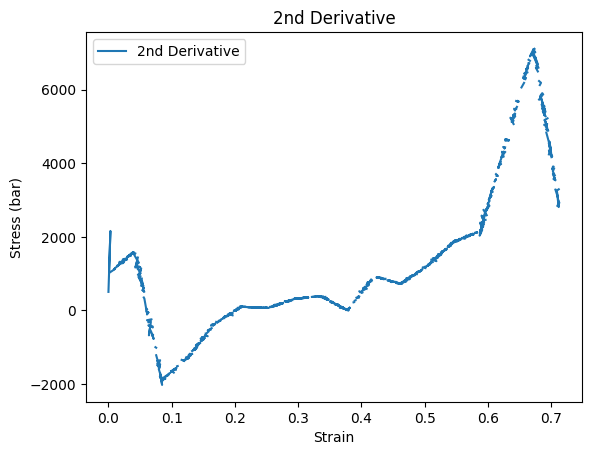

17_4_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9716238160062531
Elastic Modulus: 177.84169723726495
Plateau Slope: 76.48884858738185


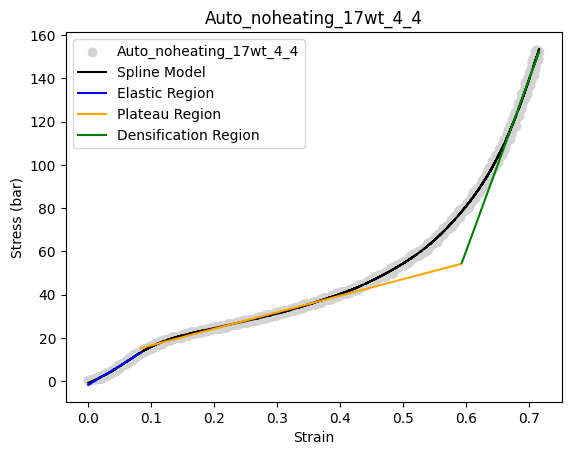

Good Fit: True


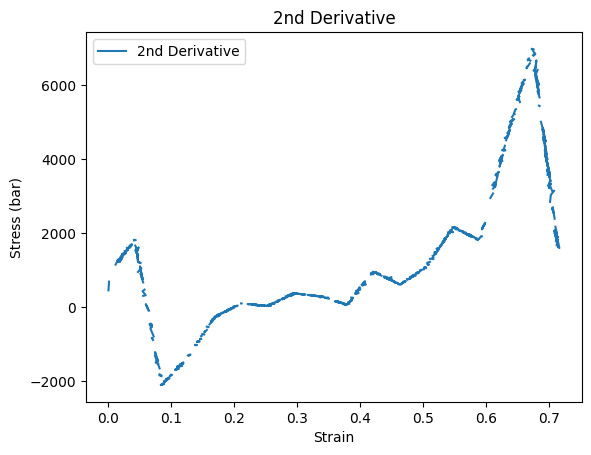

10_5_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9283635852778558
Elastic Modulus: 24.116558818402414
Plateau Slope: 81.47598887115616


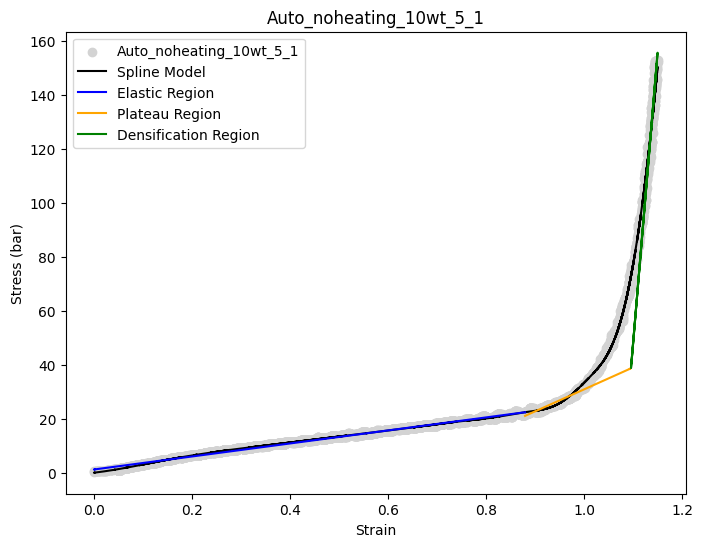

Good Fit: False


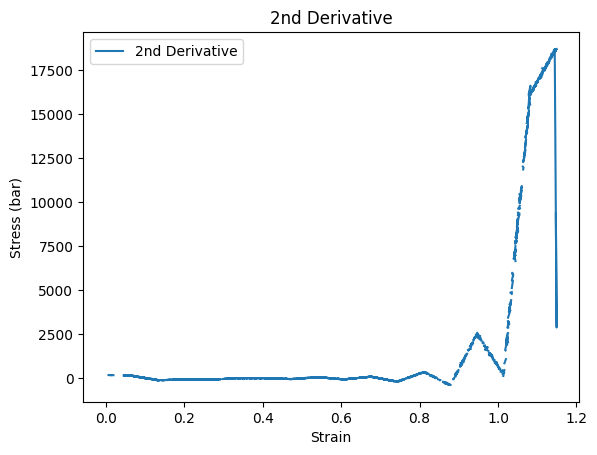

10_5_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9608286477394539
Elastic Modulus: 40.11929287495187
Plateau Slope: 47.95081366127447


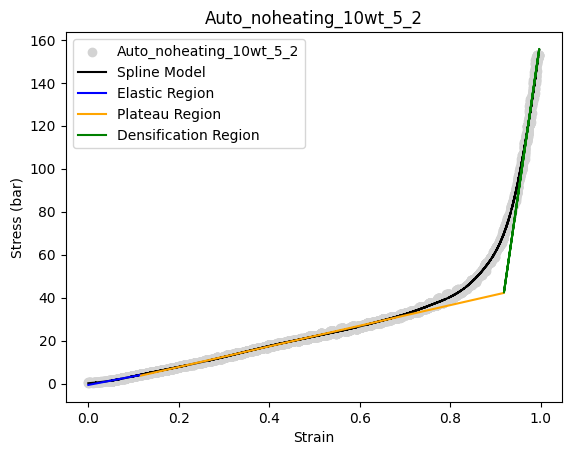

Good Fit: True


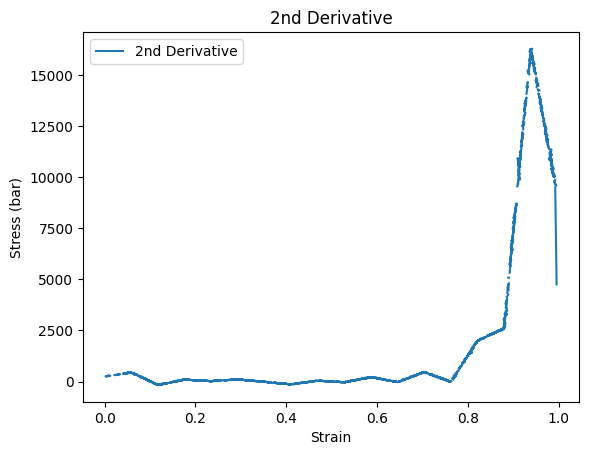

10_5_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9780487928190071
Elastic Modulus: 94.50050932386118
Plateau Slope: 151.96699342304314


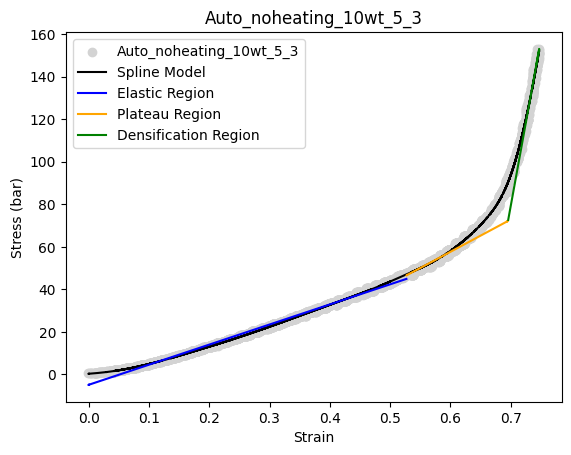

Good Fit: False


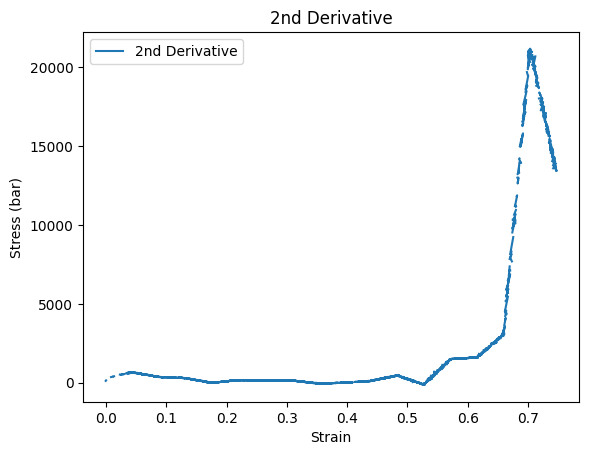

10_5_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9189490228289369
Elastic Modulus: 48.993217823344146
Plateau Slope: 61.68396315989837


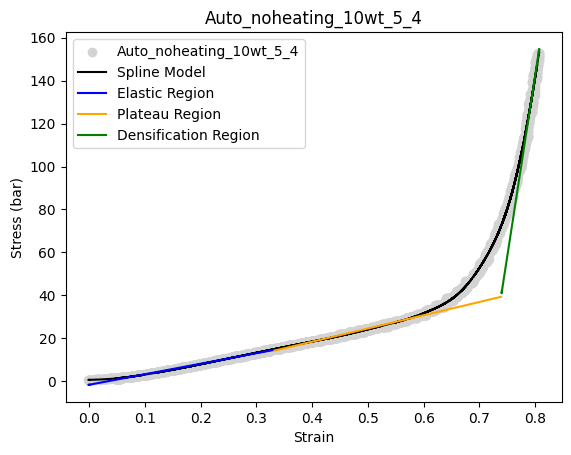

Good Fit: False


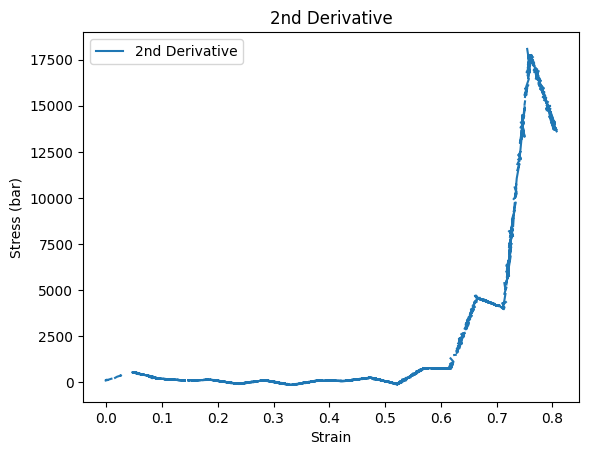

17_5_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9625302746047768
Elastic Modulus: 159.24021918170146
Plateau Slope: 71.08990566470072


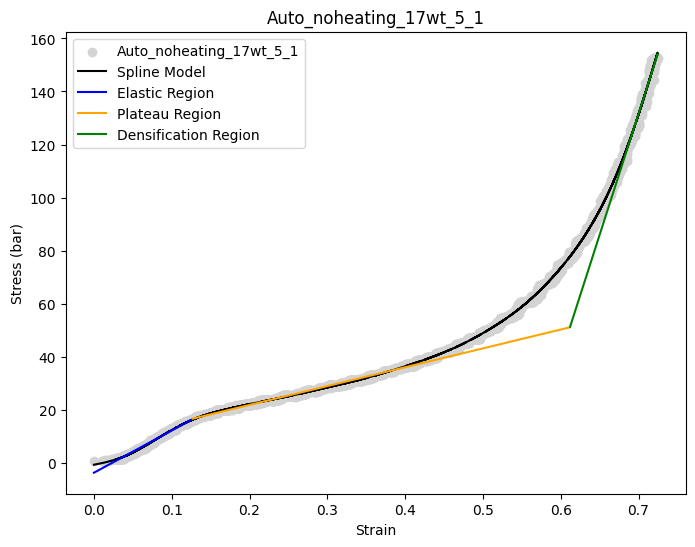

Good Fit: True


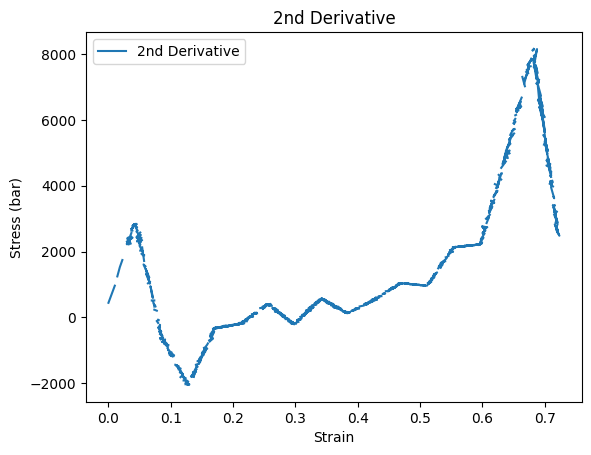

17_5_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9637235563189948
Elastic Modulus: 163.10097133420805
Plateau Slope: 73.4680608781574


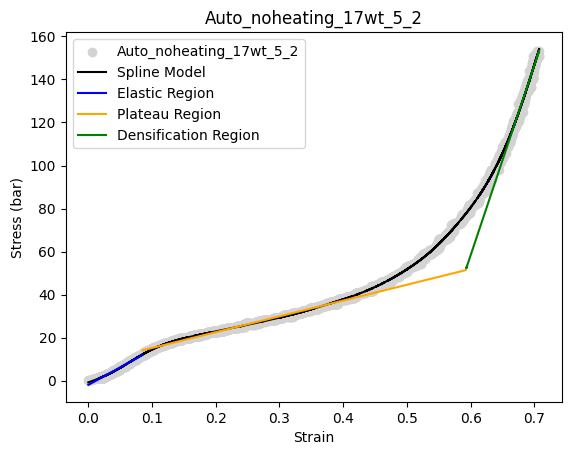

Good Fit: True


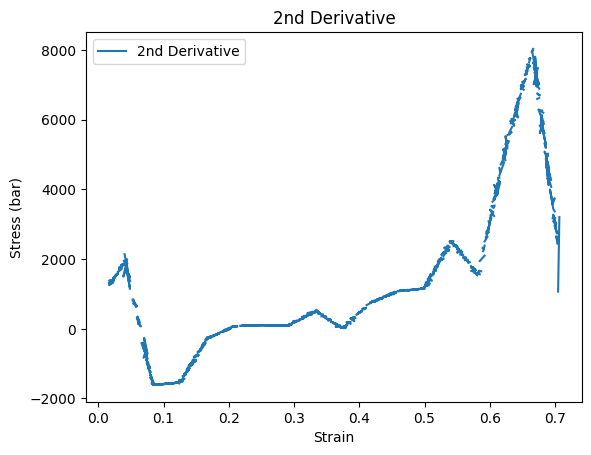

17_5_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9636702902361313
Elastic Modulus: 149.9644393877068
Plateau Slope: 71.11783263430456


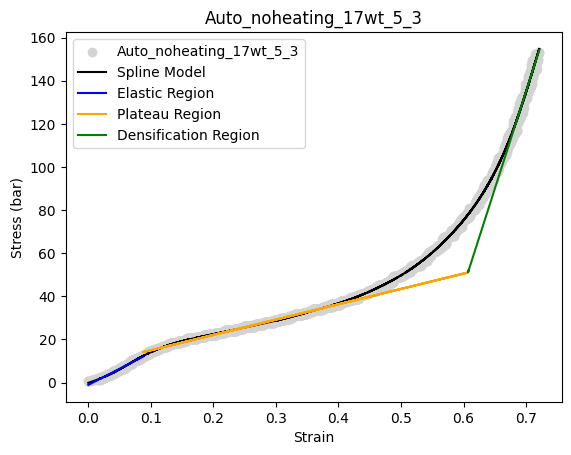

Good Fit: True


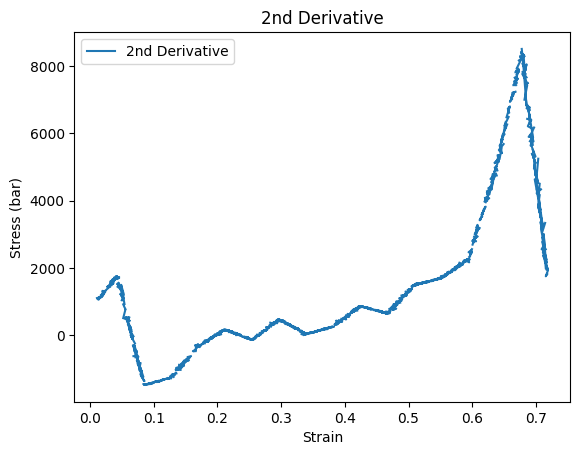

17_5_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9632021826598033
Elastic Modulus: 156.83057139216095
Plateau Slope: 70.43643050793392


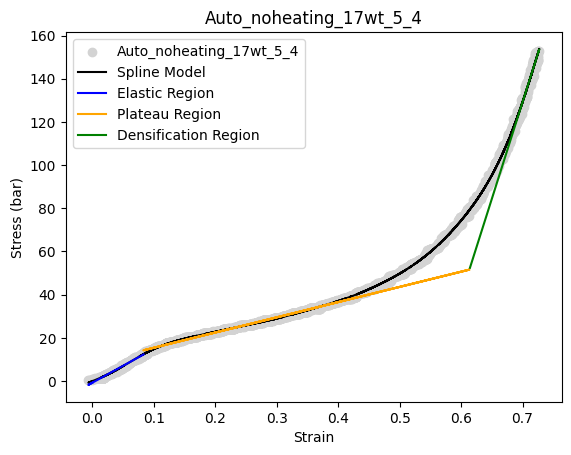

Good Fit: True


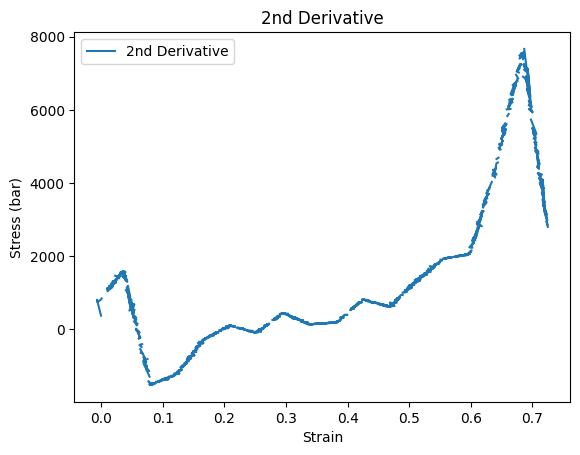

10_6_day1_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9347567304502922
Elastic Modulus: 28.228542860697093
Plateau Slope: 88.21810261935612


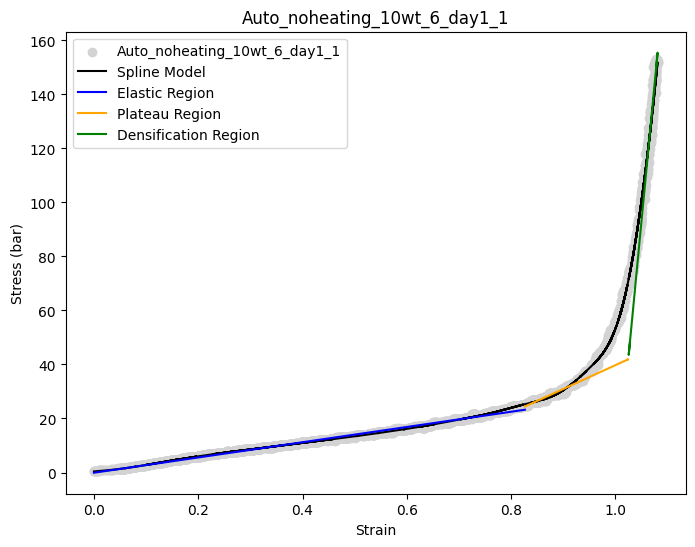

Good Fit: False


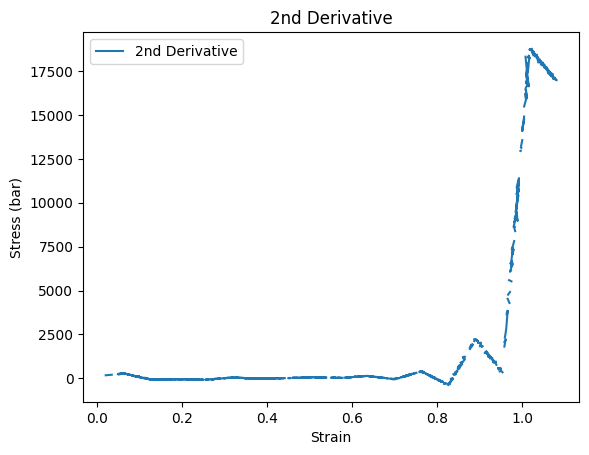

10_6_day1_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9803324662992118
Elastic Modulus: 23.06959654918484
Plateau Slope: 271.271695812888


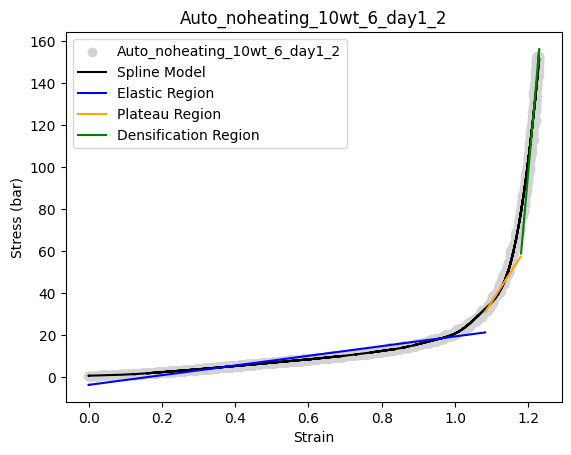

Good Fit: False


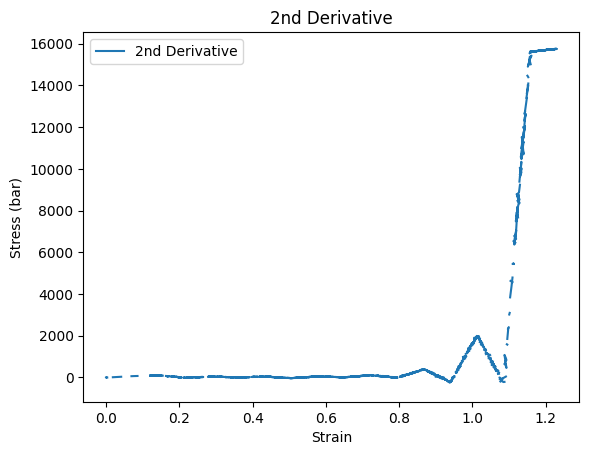

10_6_day1_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8663014549663317
Elastic Modulus: 28.413177291232817
Plateau Slope: 25.58839406349904


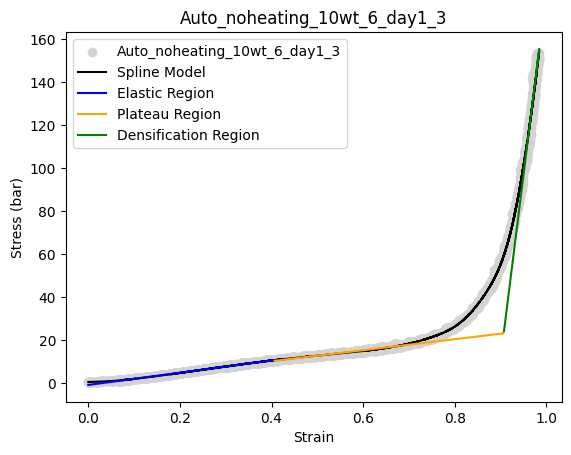

Good Fit: True


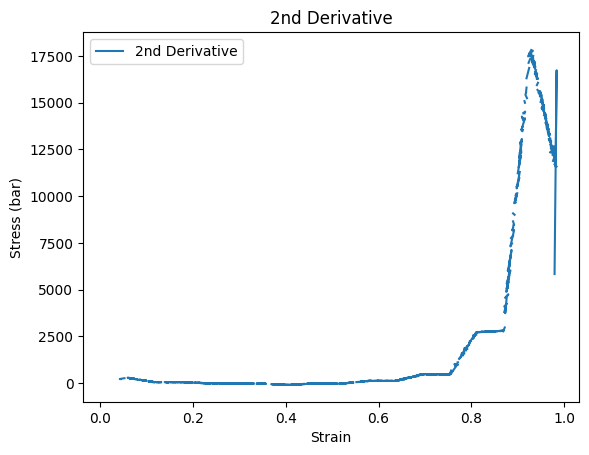

10_6_day1_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9575042541839918
Elastic Modulus: 63.93358400085063
Plateau Slope: 87.90291142201369


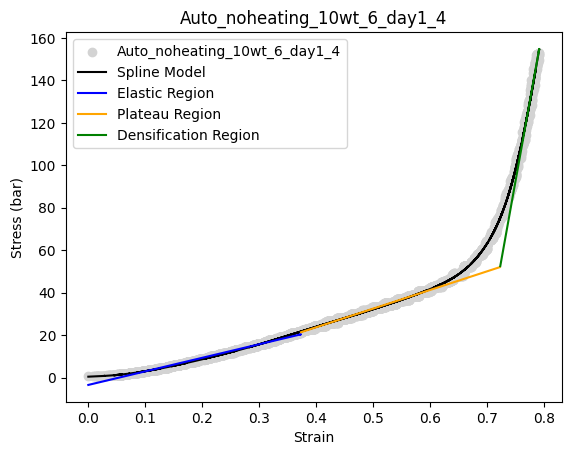

Good Fit: False


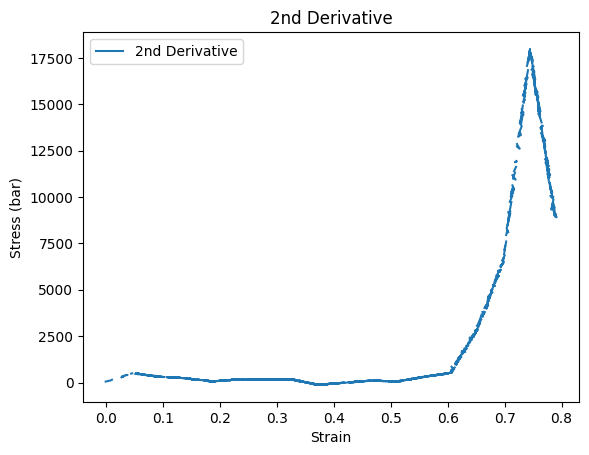

10_6_day2_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.972972935493545
Elastic Modulus: 19.869897538300197
Plateau Slope: 284.5825480851414


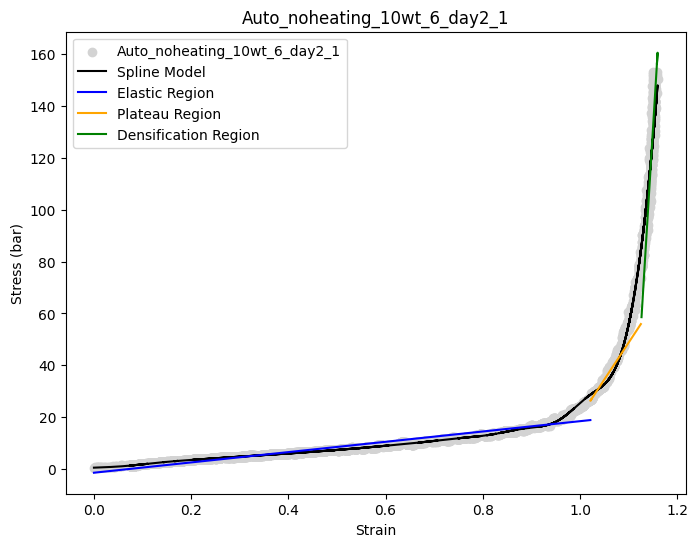

Good Fit: False


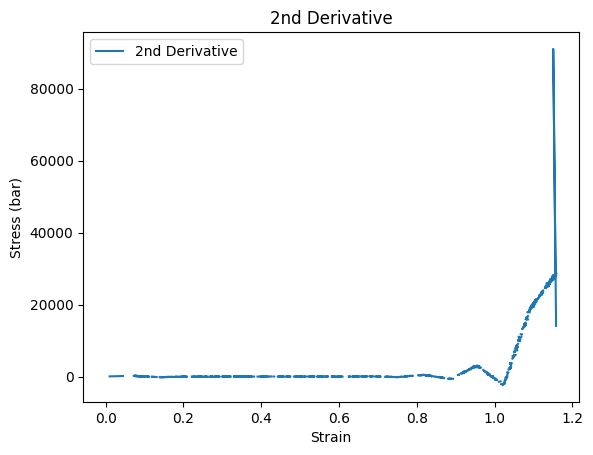

10_6_day2_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9688443299821761
Elastic Modulus: 17.809140768986172
Plateau Slope: 287.94478654588886


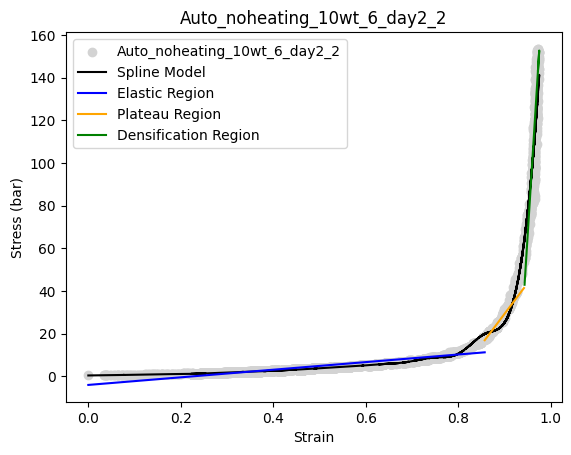

Good Fit: False


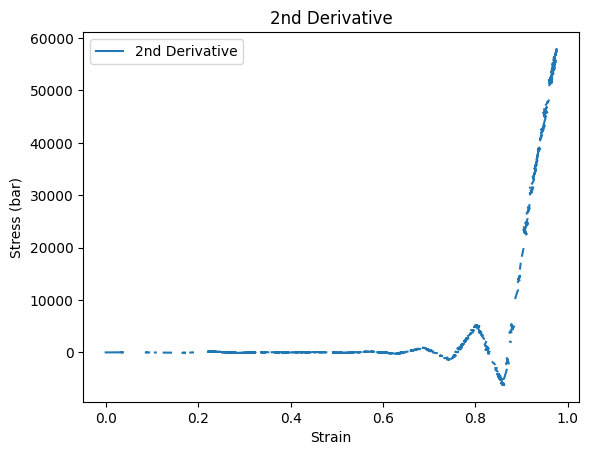

10_6_day2_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.796316759537896
Elastic Modulus: 2.210491706348625
Plateau Slope: 9.01772564464019


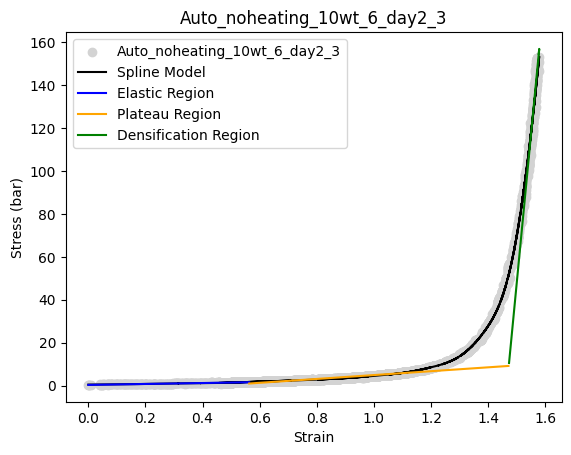

Good Fit: False


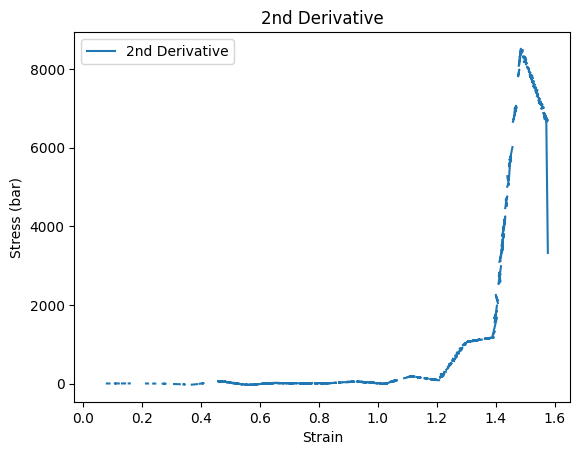

10_6_day2_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9087595254799994
Elastic Modulus: 51.04745621827881
Plateau Slope: 57.86511108973247


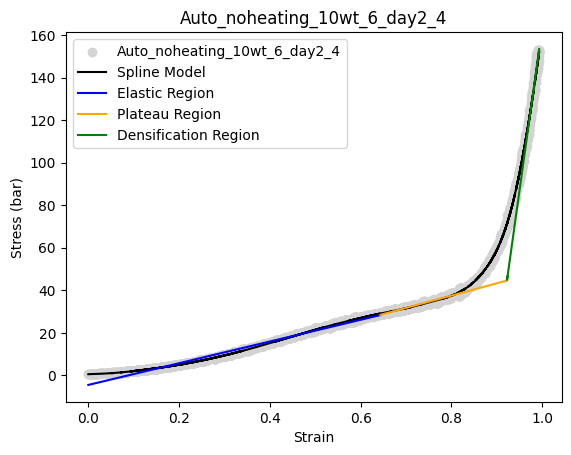

Good Fit: True


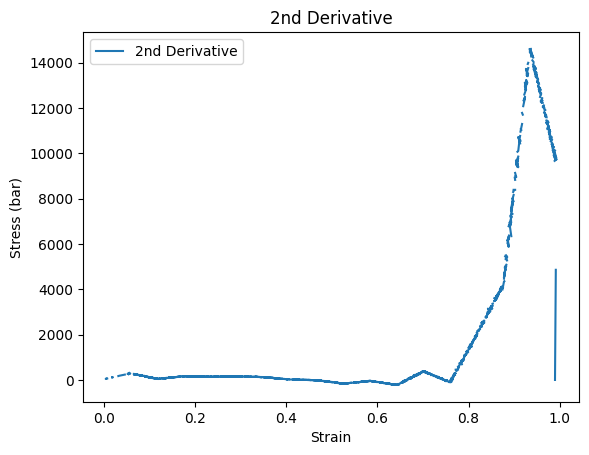

10_6_day2_5
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9542676752206697
Elastic Modulus: 102.69237906552988
Plateau Slope: 106.49011321118127


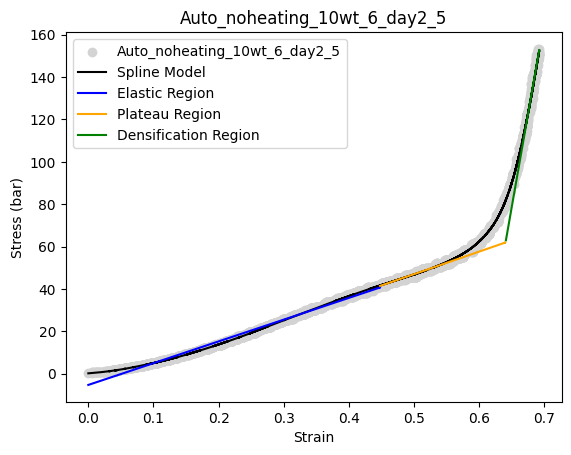

Good Fit: True


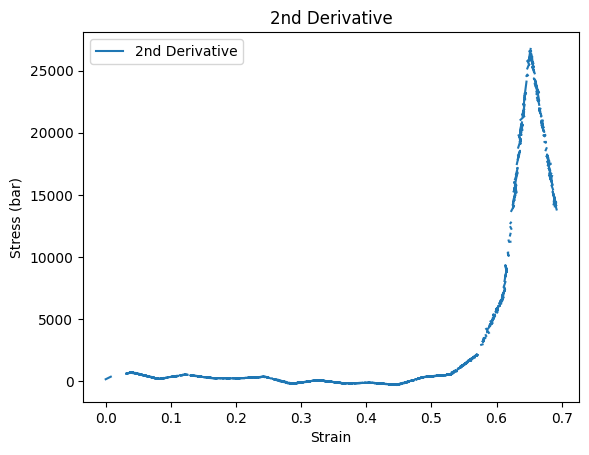

10_6_day3_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8872166849615267
Elastic Modulus: 14.292620251031487
Plateau Slope: 22.45760425279427


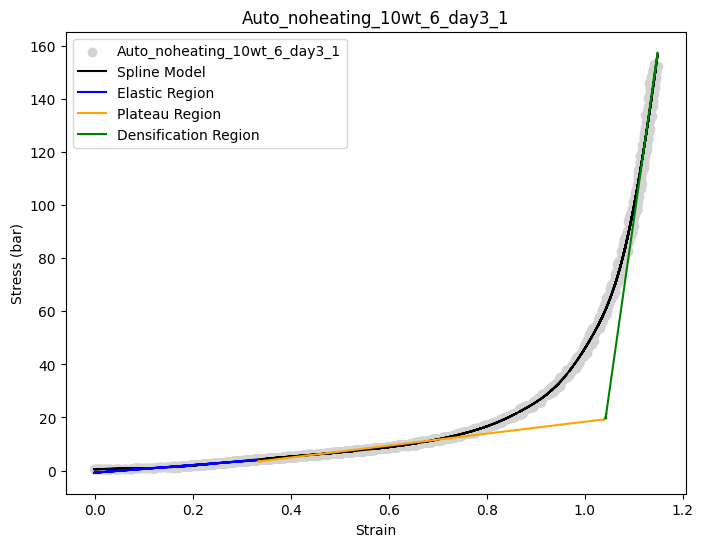

Good Fit: False


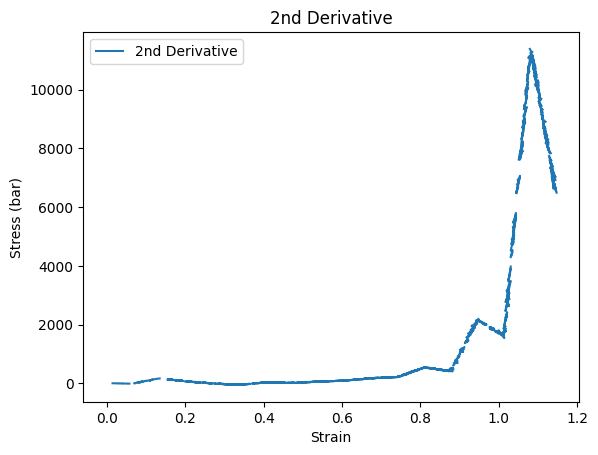

10_6_day3_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9044850017224663
Elastic Modulus: 17.144890427751477
Plateau Slope: 23.400977289320146


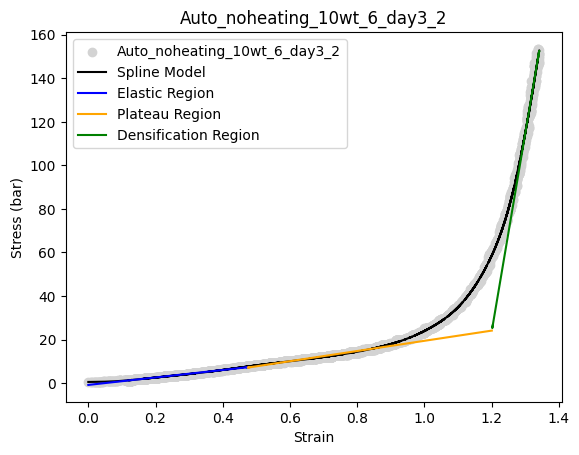

Good Fit: False


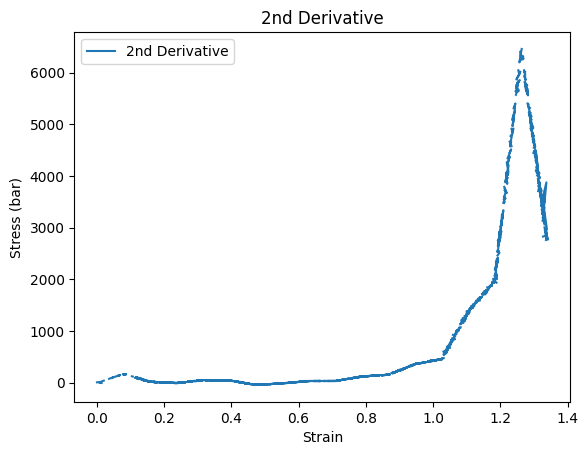

10_6_day3_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.962556170559731
Elastic Modulus: 62.145474236252745
Plateau Slope: 67.50501797926788


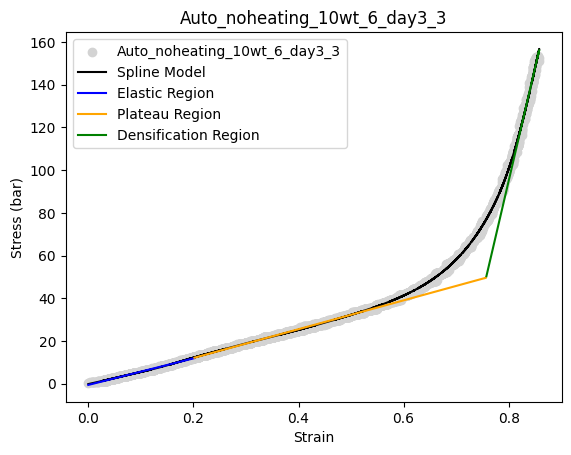

Good Fit: True


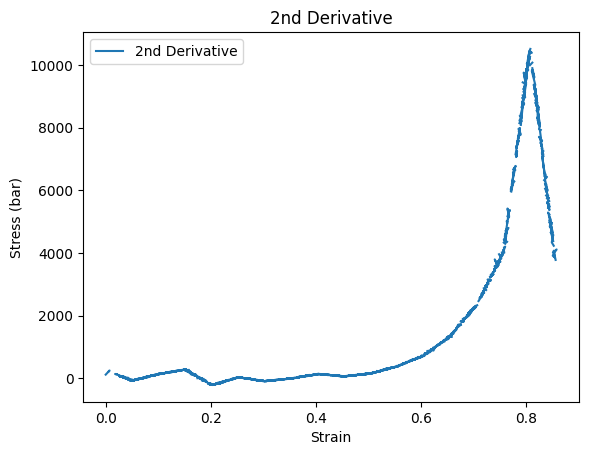

10_6_day3_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9413278103370053
Elastic Modulus: 68.82457057101959
Plateau Slope: 47.06795420346212


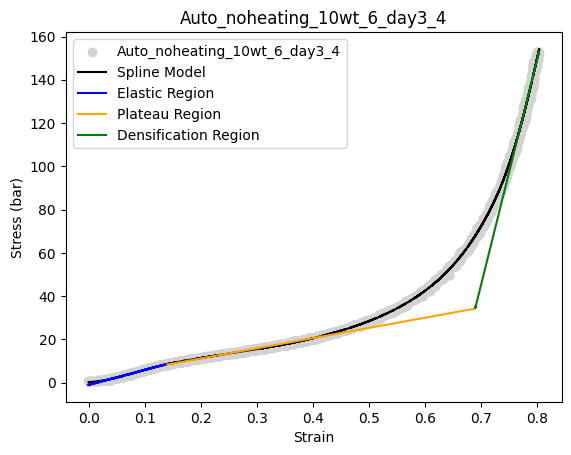

Good Fit: True


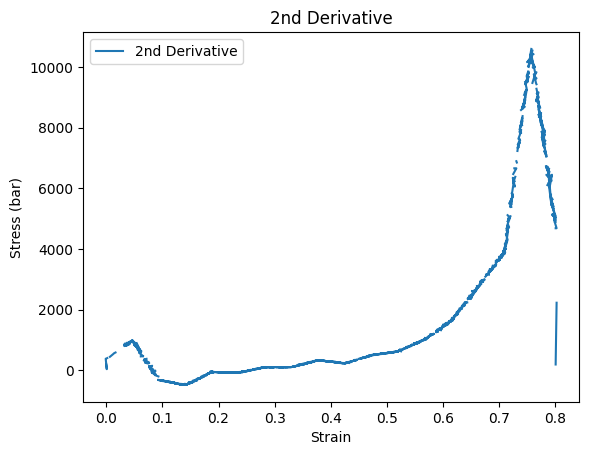

10_6_day3_5
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9271754080062509
Elastic Modulus: 77.51937494631511
Plateau Slope: 47.04089529750911


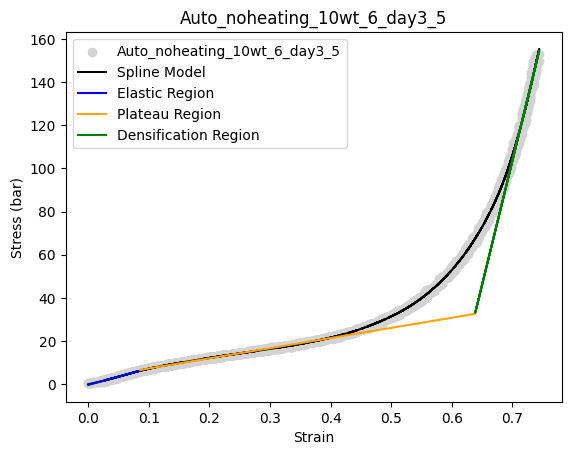

Good Fit: True


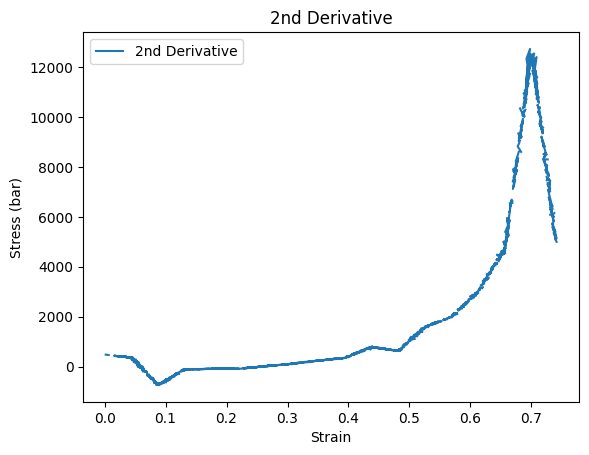

12_7_1_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9550489733081837
Elastic Modulus: 82.02822606266957
Plateau Slope: 63.95170924481042


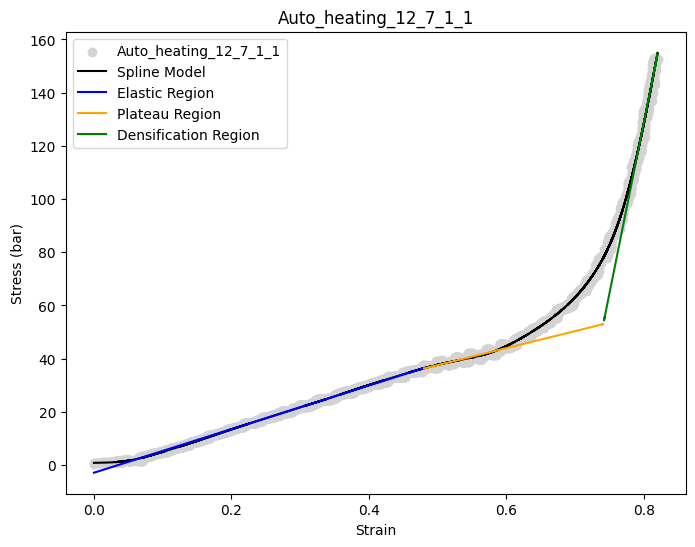

Good Fit: True


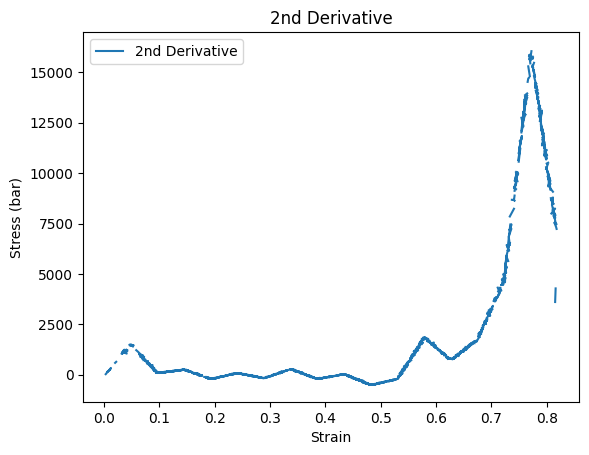

12_7_1_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8868136658303927
Elastic Modulus: 107.34330993236303
Plateau Slope: 48.58059098664799


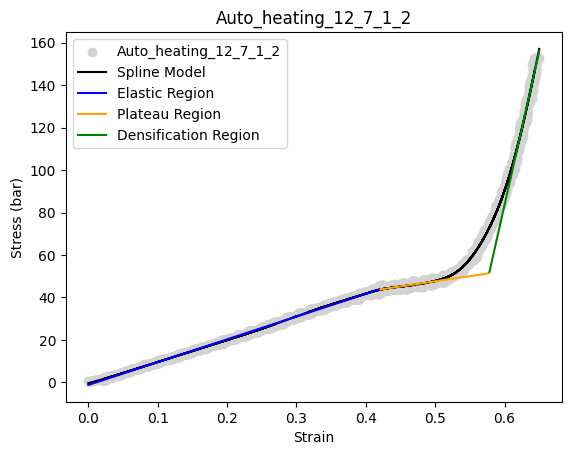

Good Fit: True


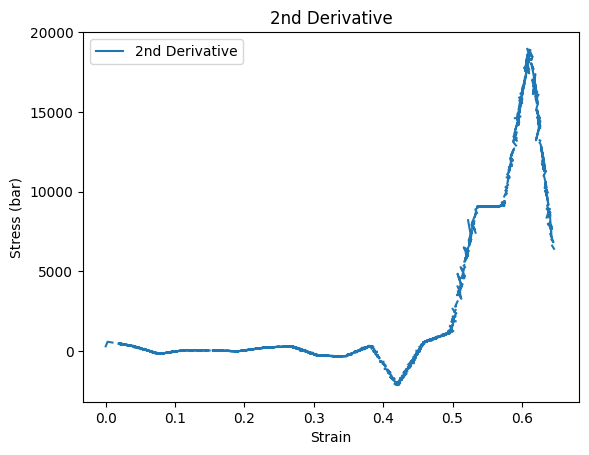

12_7_1_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8858017783617396
Elastic Modulus: 98.69083100280965
Plateau Slope: 48.92591899850621


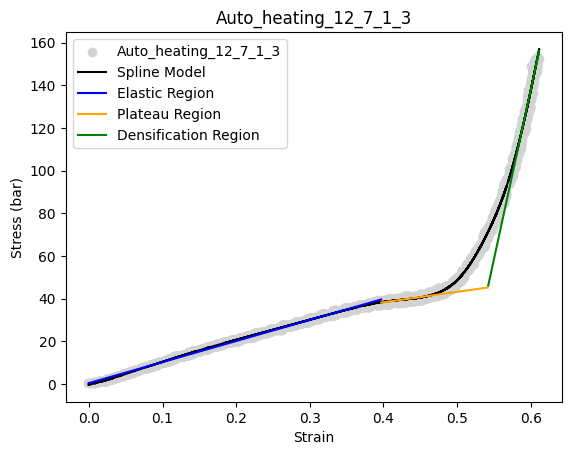

Good Fit: True


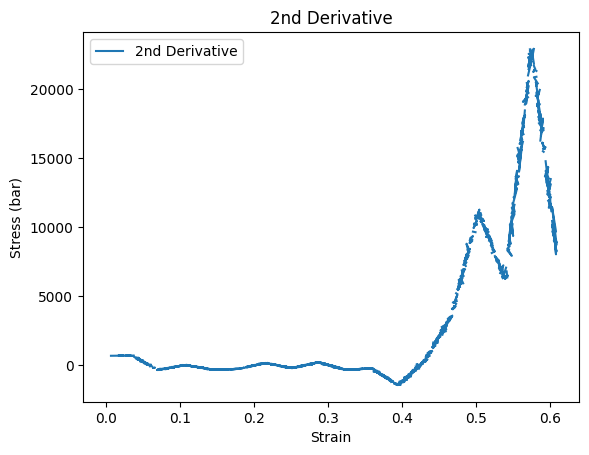

12_7_1_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8805460203759427
Elastic Modulus: 95.36621783346223
Plateau Slope: 16.58025238475268


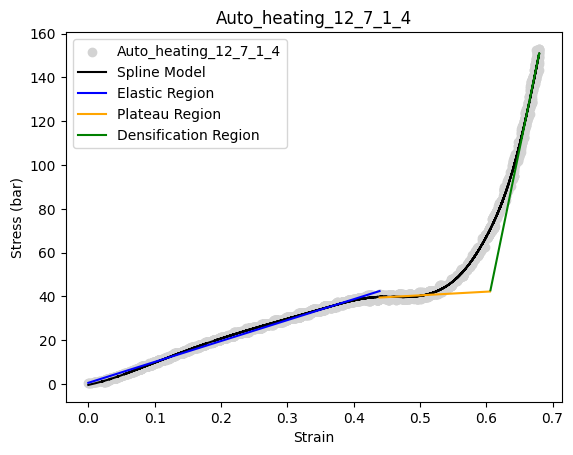

Good Fit: True


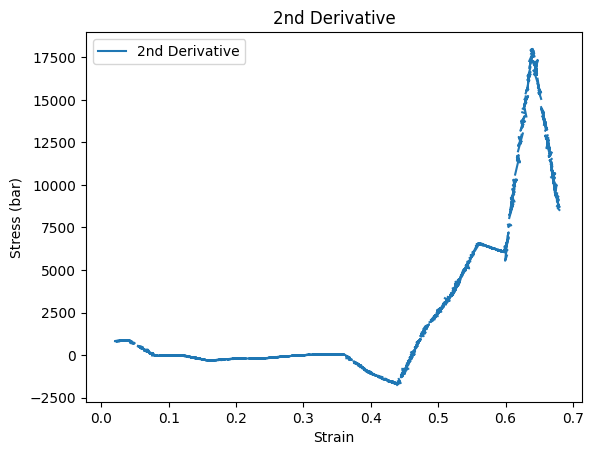

12_7_2_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9724115303923394
Elastic Modulus: 81.34497971683616
Plateau Slope: 64.23175667851194


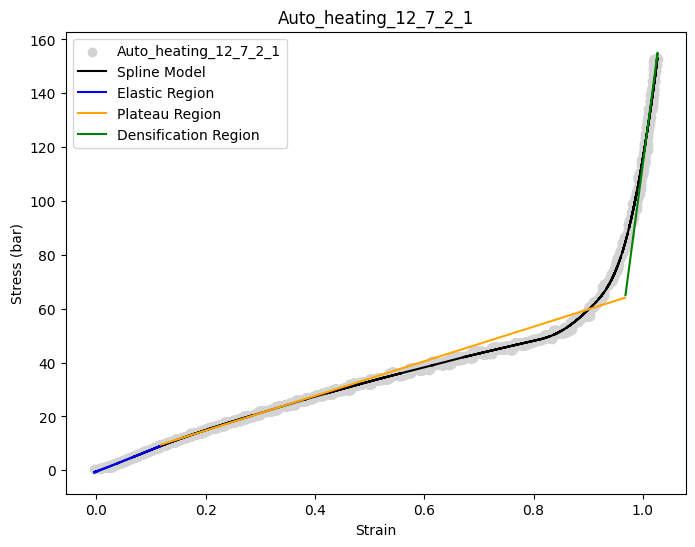

Good Fit: True


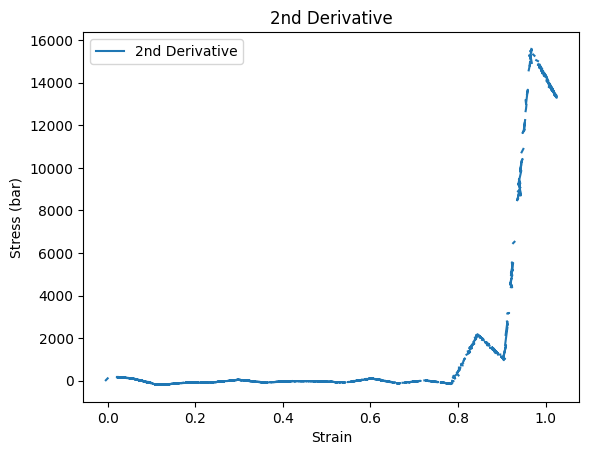

12_7_2_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9713371131132247
Elastic Modulus: 92.60215746630357
Plateau Slope: 41.13620085225387


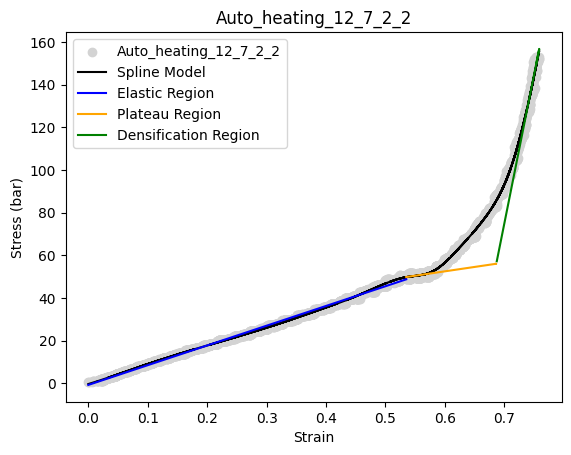

Good Fit: True


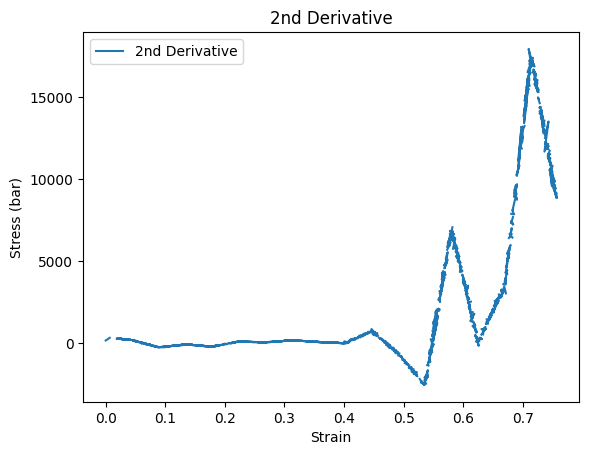

12_7_2_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9345579009056943
Elastic Modulus: 103.347425277445
Plateau Slope: 52.382067542662476


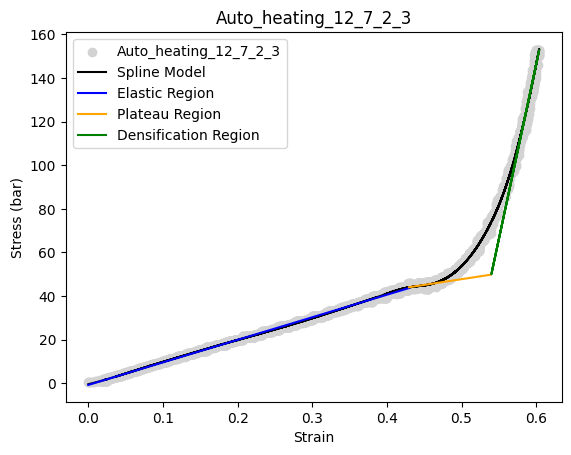

Good Fit: True


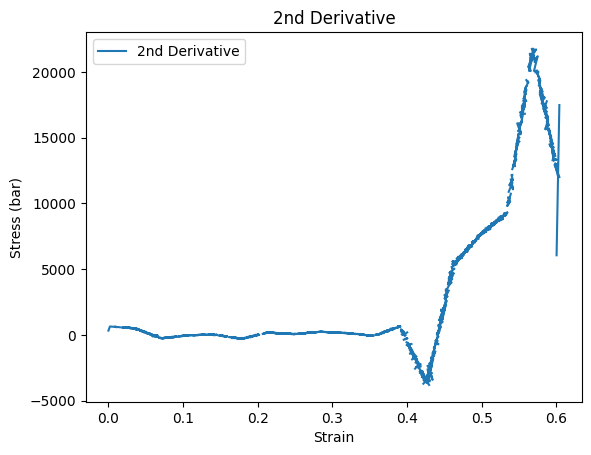

12_7_2_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9121272706741053
Elastic Modulus: 87.1374247535215
Plateau Slope: 50.56309639798335


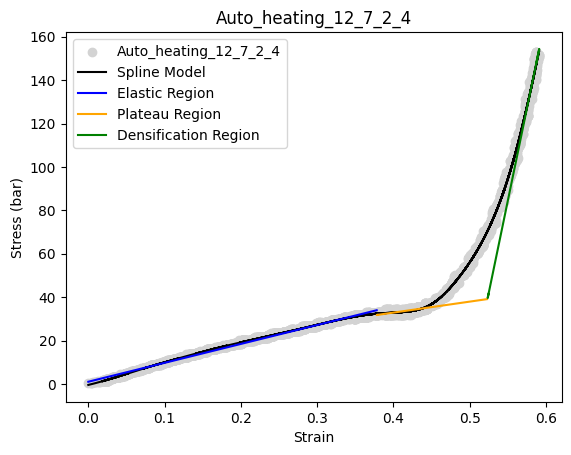

Good Fit: True


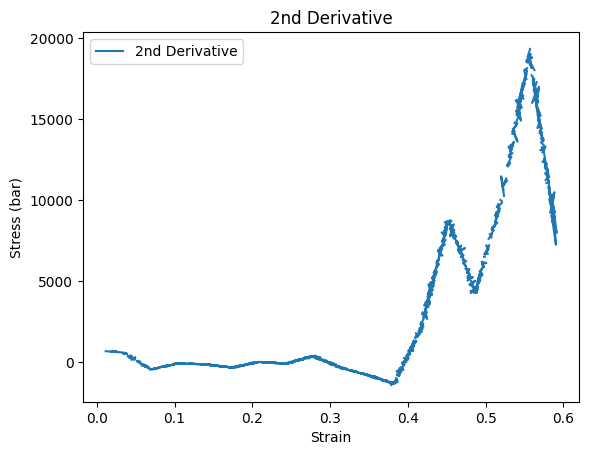

12_8_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9189907356581354
Elastic Modulus: 62.56696201372417
Plateau Slope: 32.25295230661648


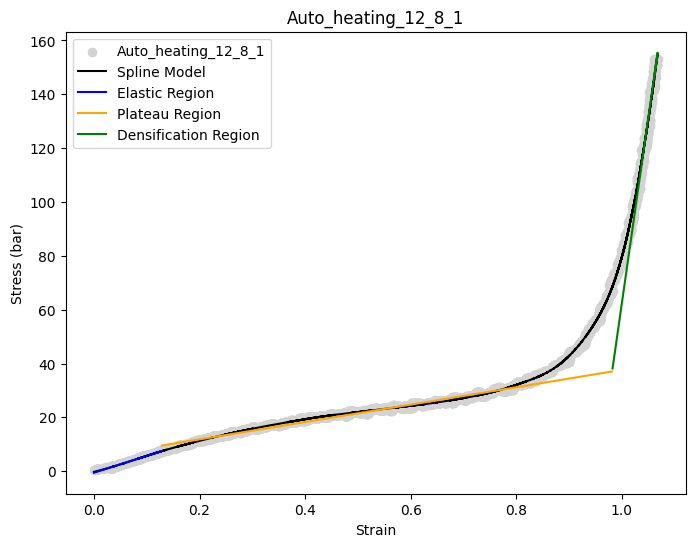

Good Fit: True


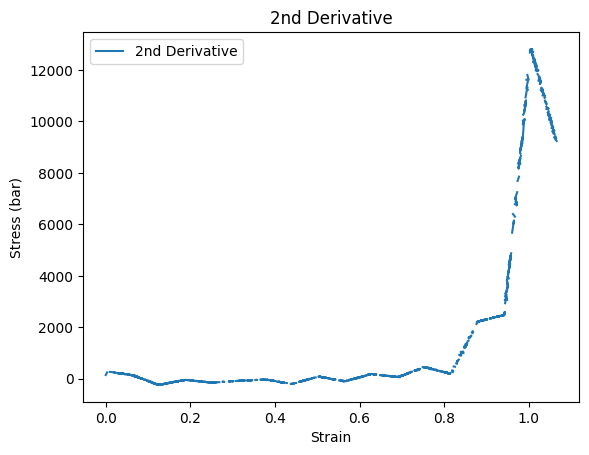

12_8_2


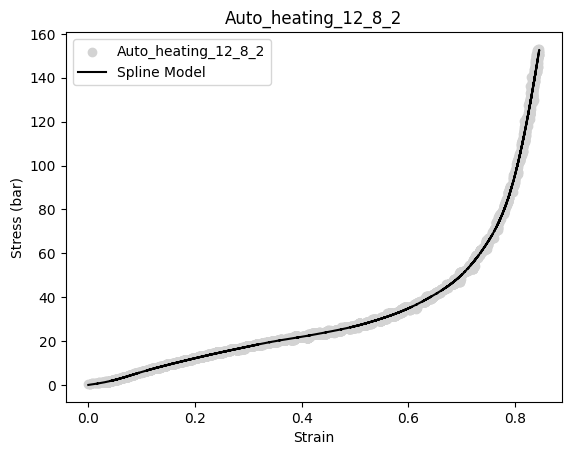

Good Fit: None


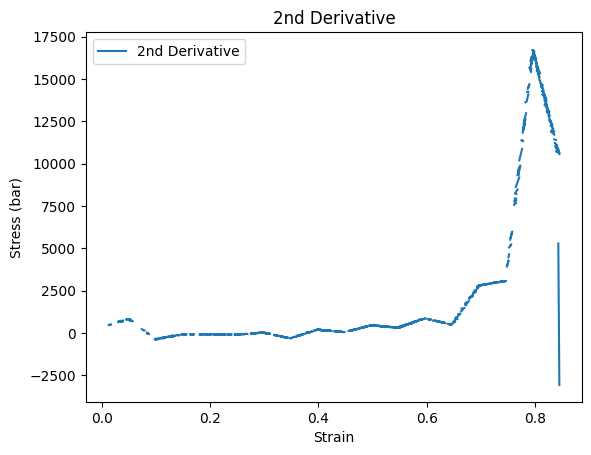

12_8_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9083194615726539
Elastic Modulus: 68.91570647417674
Plateau Slope: 56.56025364979936


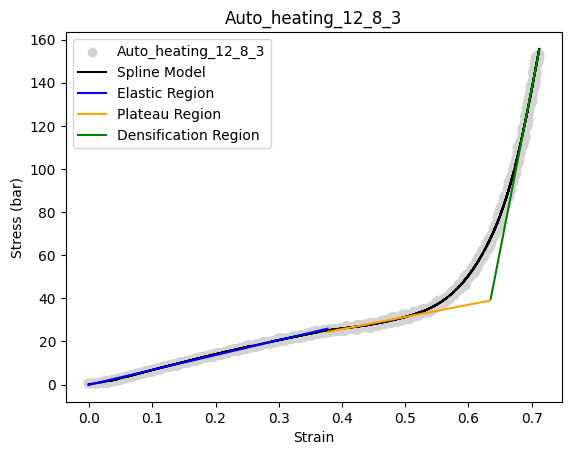

Good Fit: True


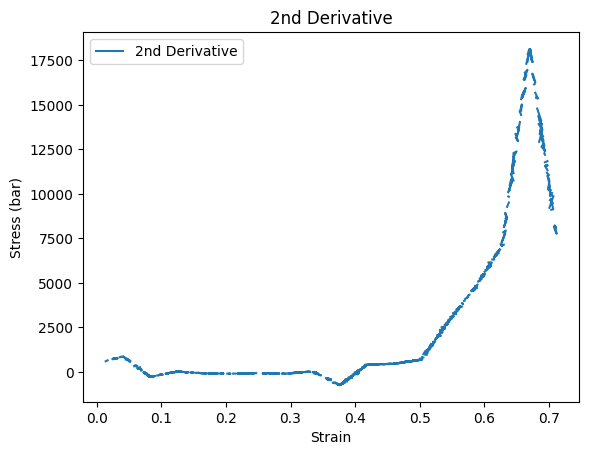

12_8_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9180431526099841
Elastic Modulus: 61.360981292036406
Plateau Slope: 51.365923937129004


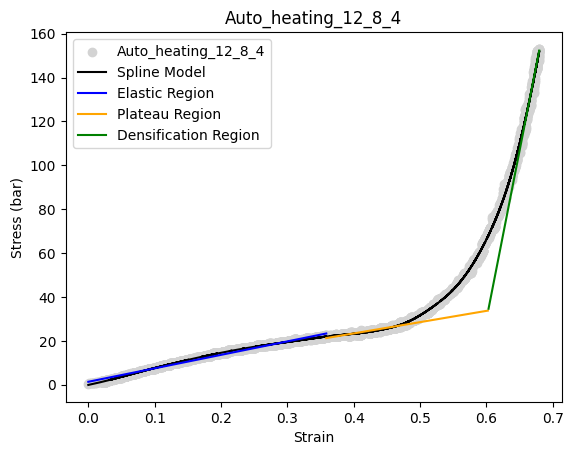

Good Fit: True


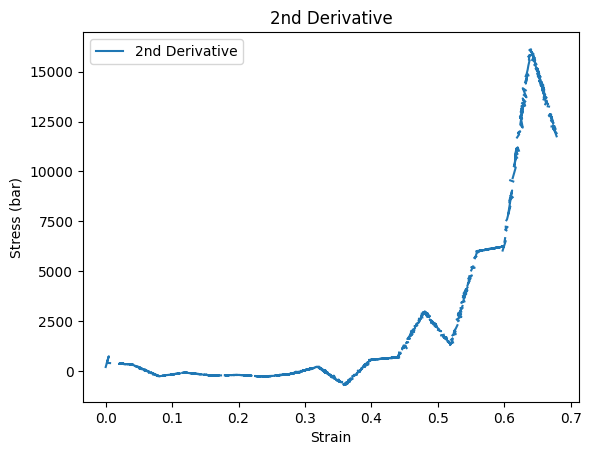

17_8_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9650472545726412
Elastic Modulus: 161.44011603636463
Plateau Slope: 71.74112641487086


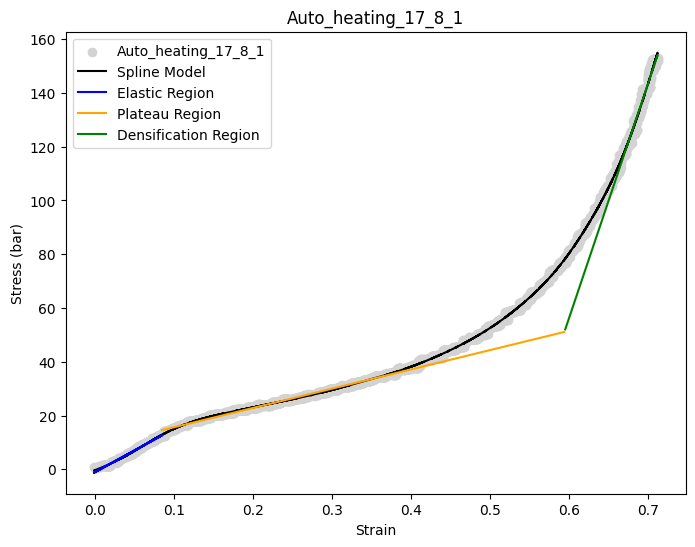

Good Fit: True


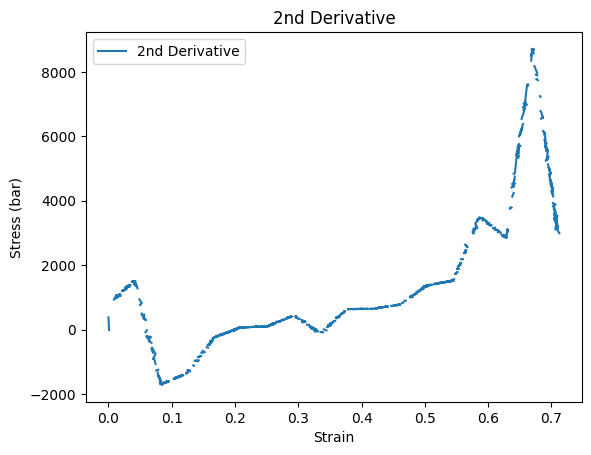

17_8_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9654755592293284
Elastic Modulus: 166.09895643189114
Plateau Slope: 73.52225050436017


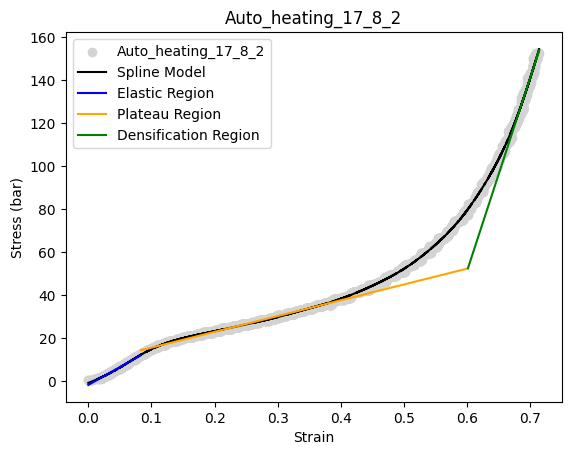

Good Fit: True


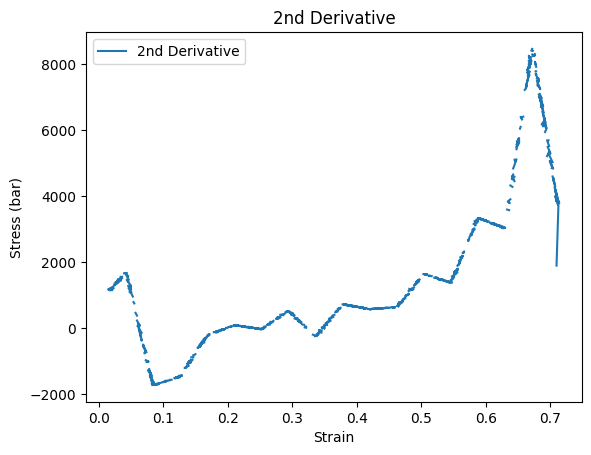

17_8_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9676630432454275
Elastic Modulus: 174.52552632140518
Plateau Slope: 76.11105038779058


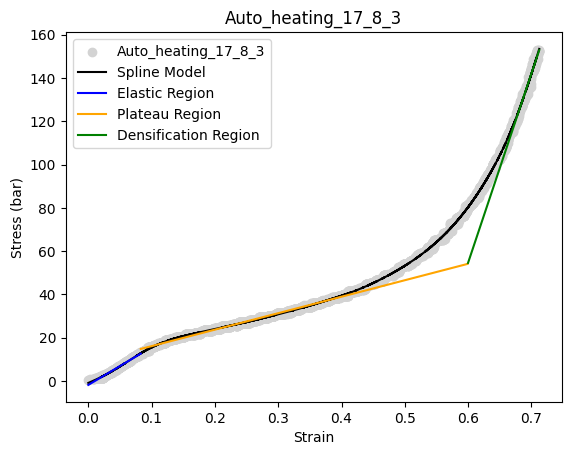

Good Fit: True


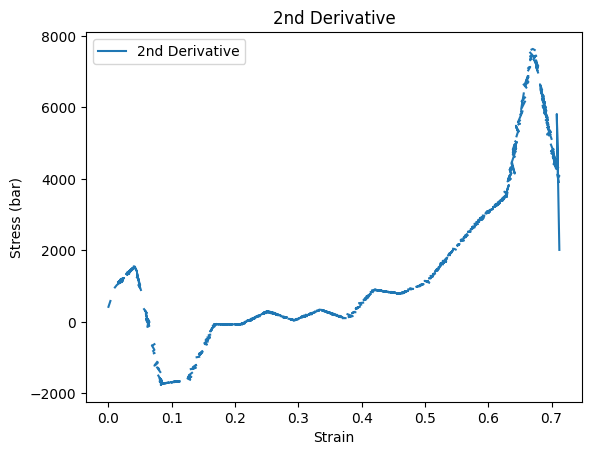

17_8_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9649793257369818
Elastic Modulus: 180.02011307929
Plateau Slope: 76.6986034838654


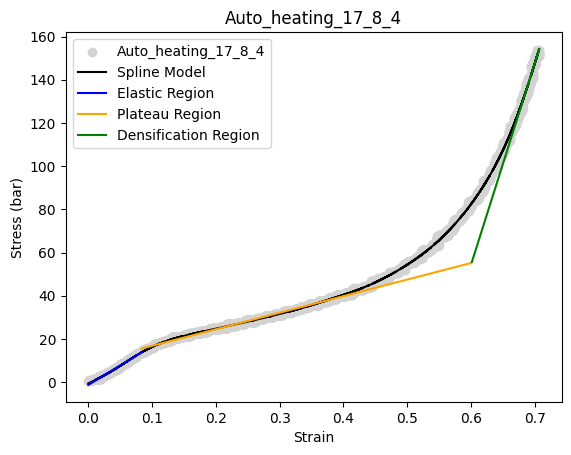

Good Fit: True


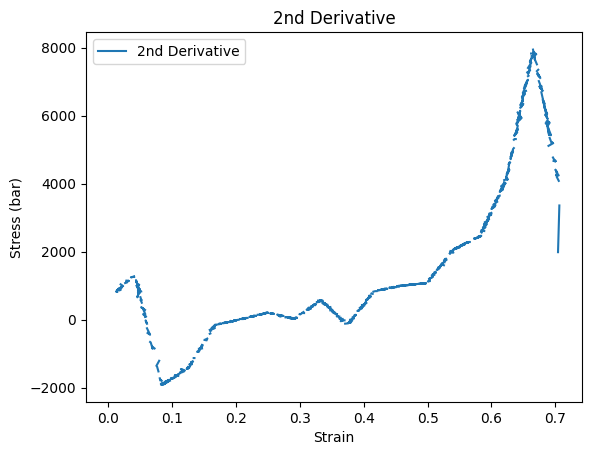

13_9_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8533707984019642
Elastic Modulus: 68.49178099204498
Plateau Slope: 26.496497394070524


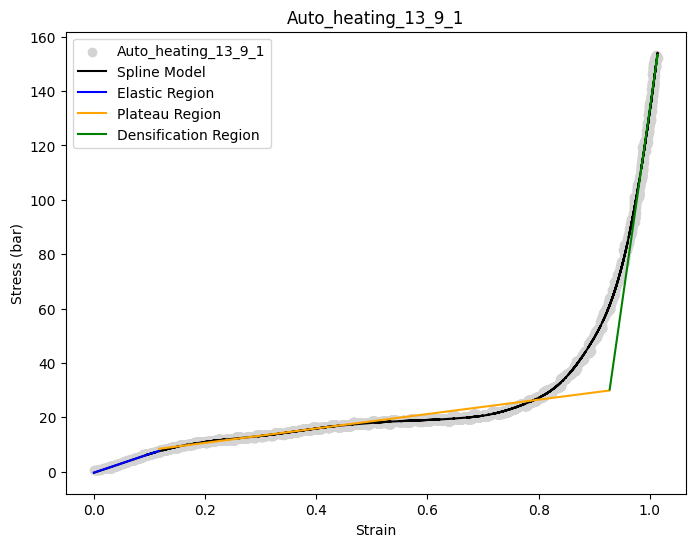

Good Fit: True


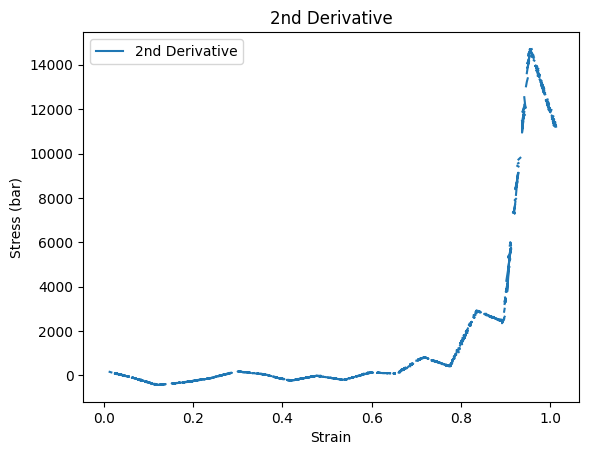

13_9_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8420561305746003
Elastic Modulus: 71.2300891627639
Plateau Slope: 19.966856694811494


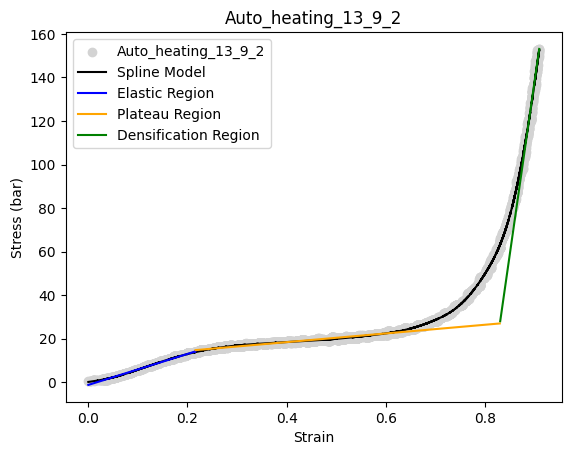

Good Fit: True


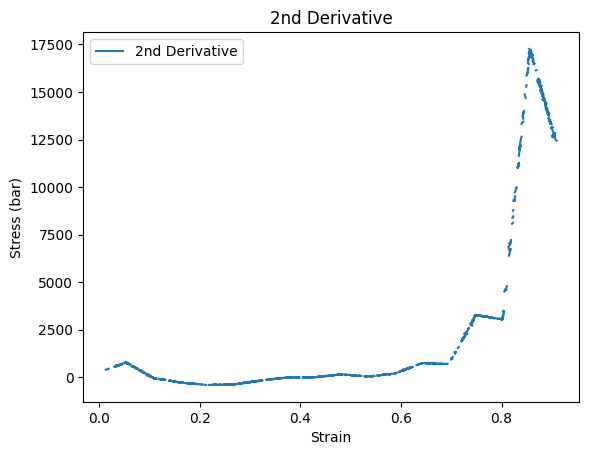

13_9_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8395443567826392
Elastic Modulus: 54.484868594115405
Plateau Slope: 12.588326527735791


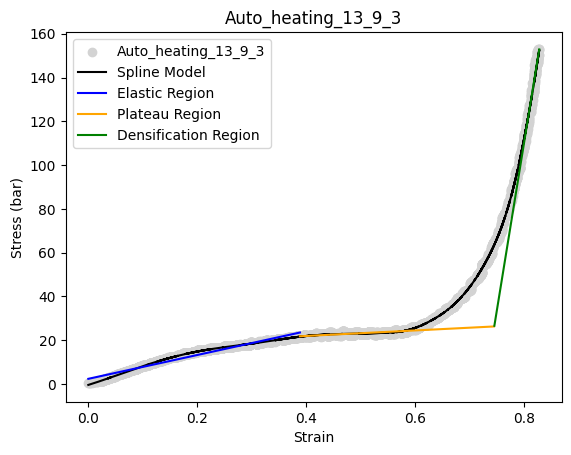

Good Fit: True


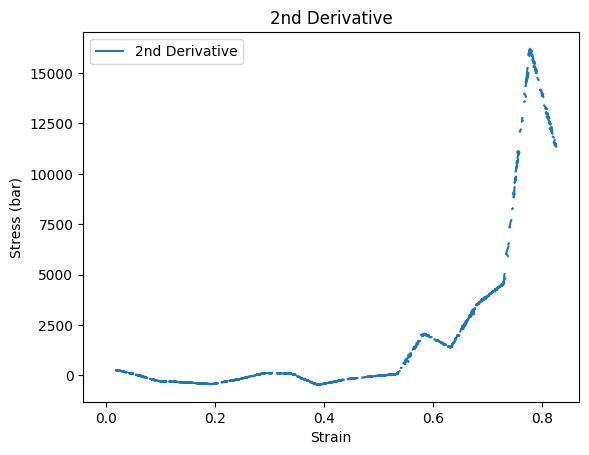

13_9_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8780553521422866
Elastic Modulus: 69.66017902686076
Plateau Slope: 36.58704360296161


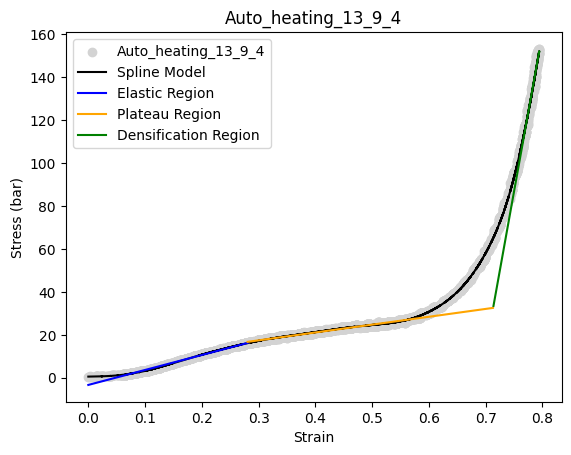

Good Fit: True


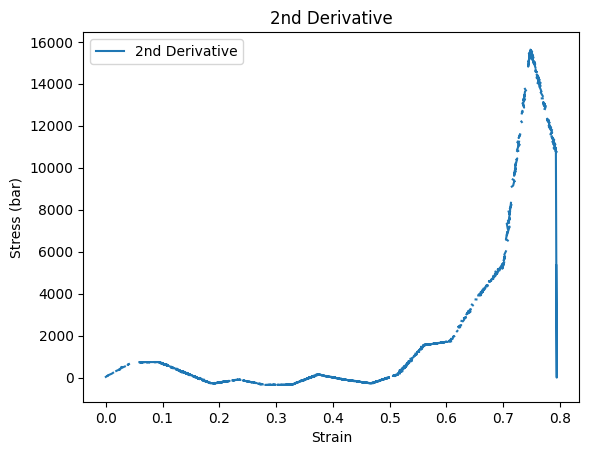

17_10_1


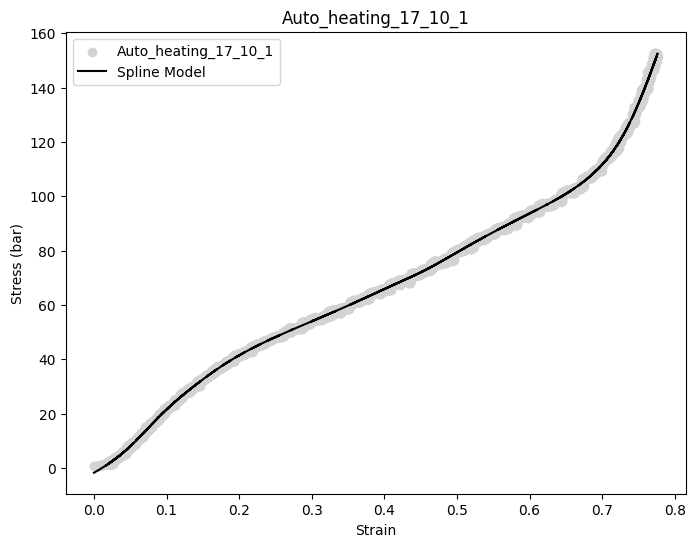

Good Fit: None


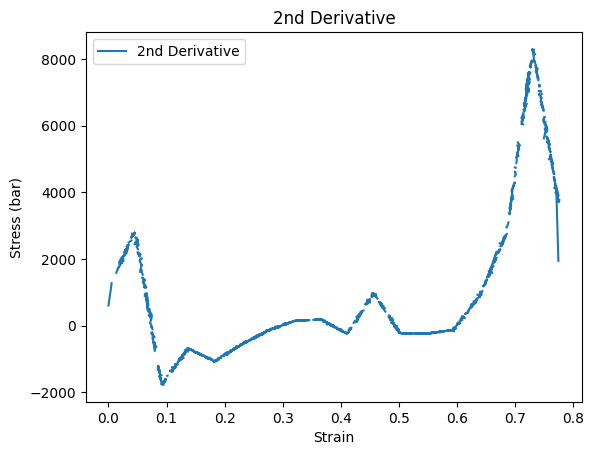

17_10_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9876233433777495
Elastic Modulus: 265.47516868240115
Plateau Slope: 240.22899191389394


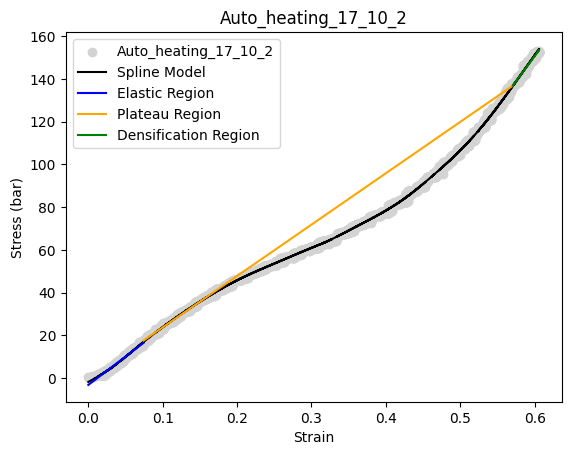

Good Fit: False


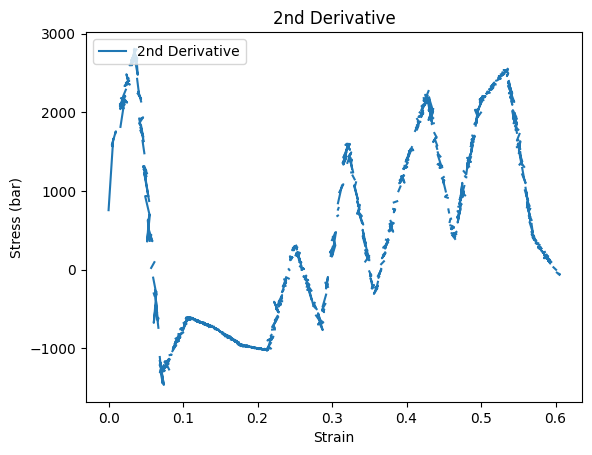

17_10_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9892083449144522
Elastic Modulus: 293.07566794471774
Plateau Slope: 256.0026333244531


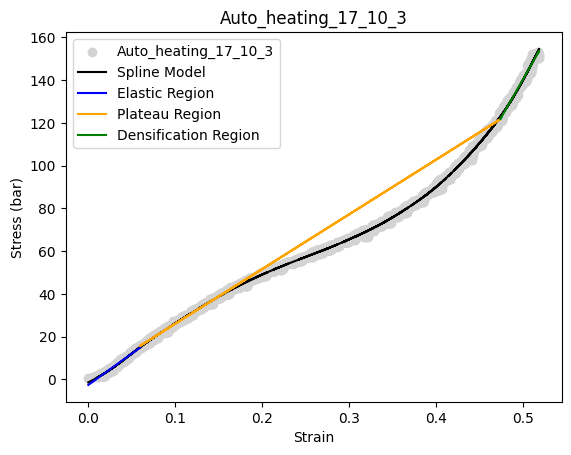

Good Fit: False


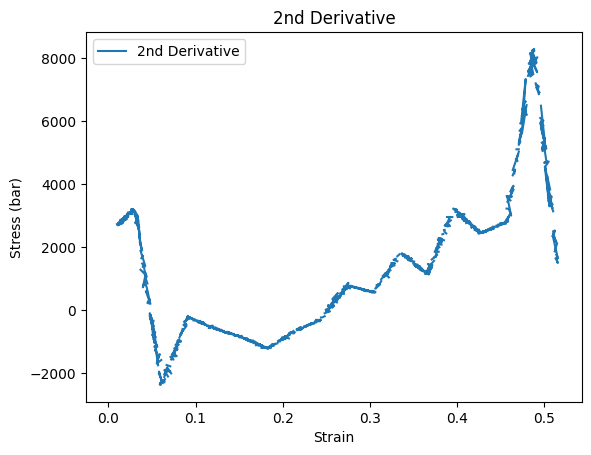

17_10_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9858062716530569
Elastic Modulus: 273.40961025786663
Plateau Slope: 248.56826617031857


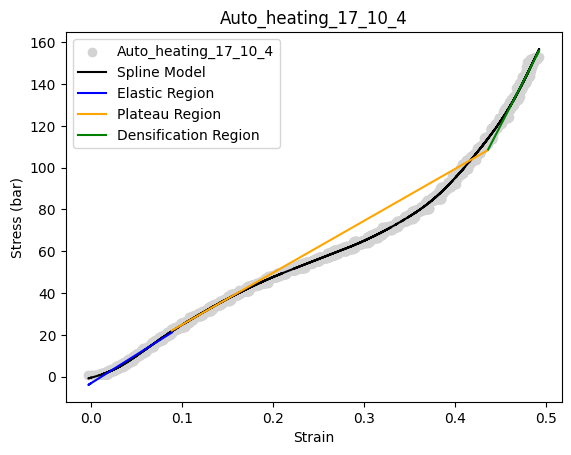

Good Fit: False


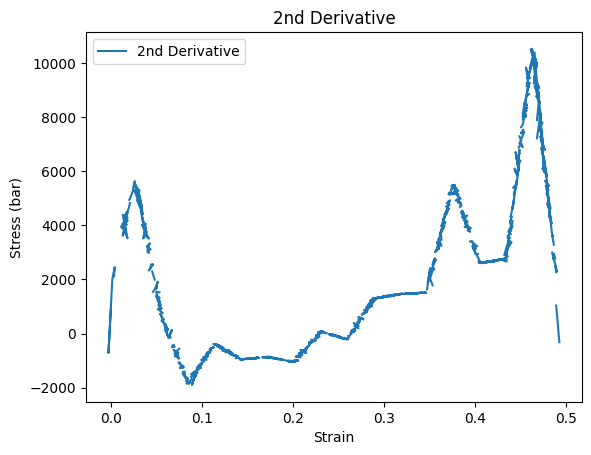

17_10_5


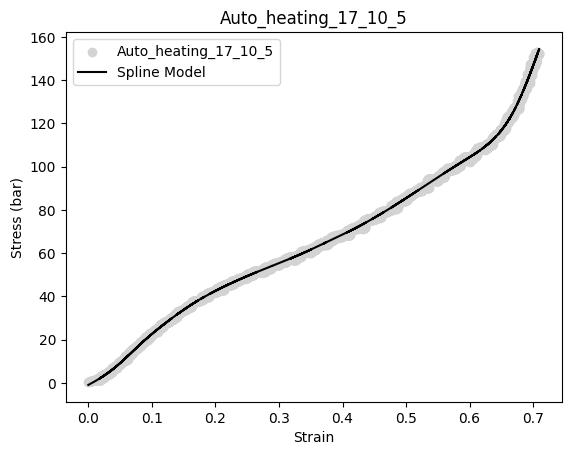

Good Fit: None


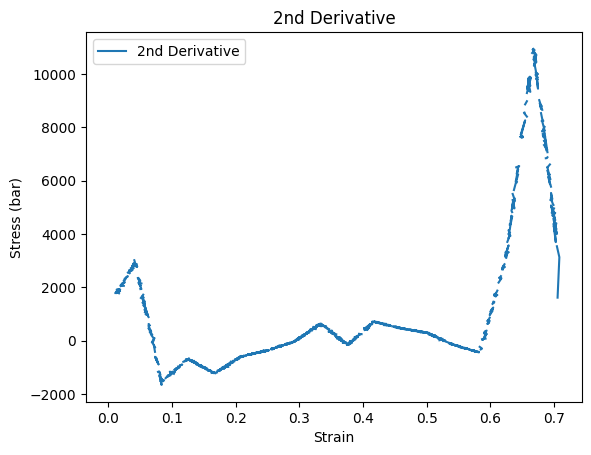

17_10_6


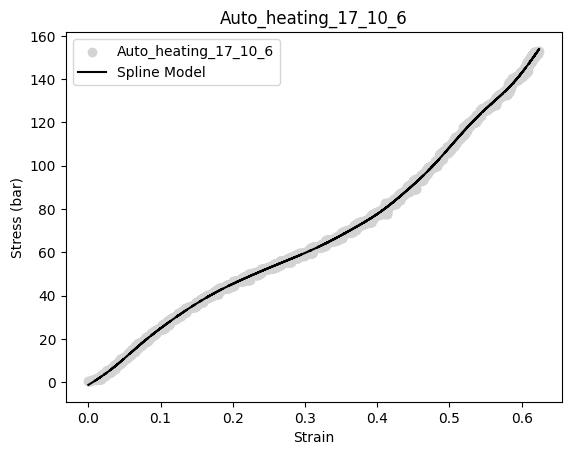

Good Fit: None


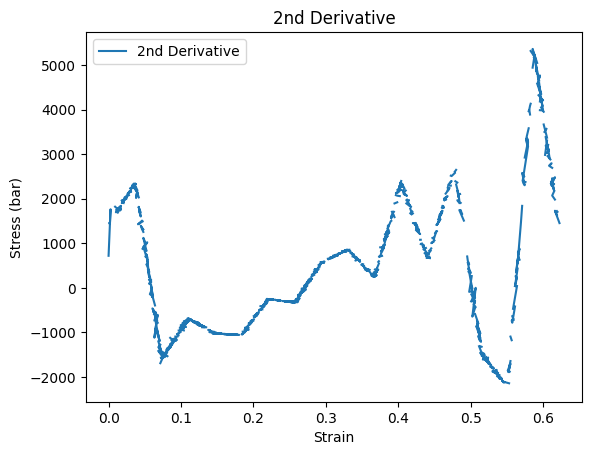

17_10_7
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9902645581366957
Elastic Modulus: 253.044589054906
Plateau Slope: 144.80329820529803


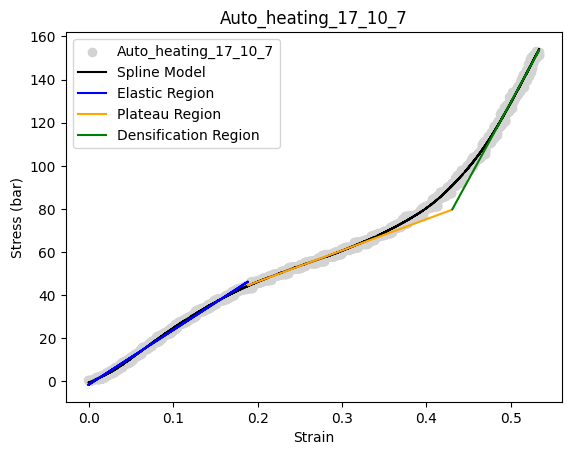

Good Fit: False


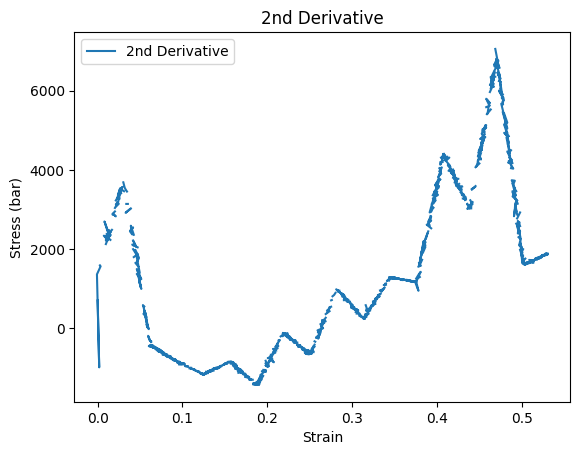

10_11_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8786826659622144
Elastic Modulus: 20.160039624559975
Plateau Slope: 20.880055741735102


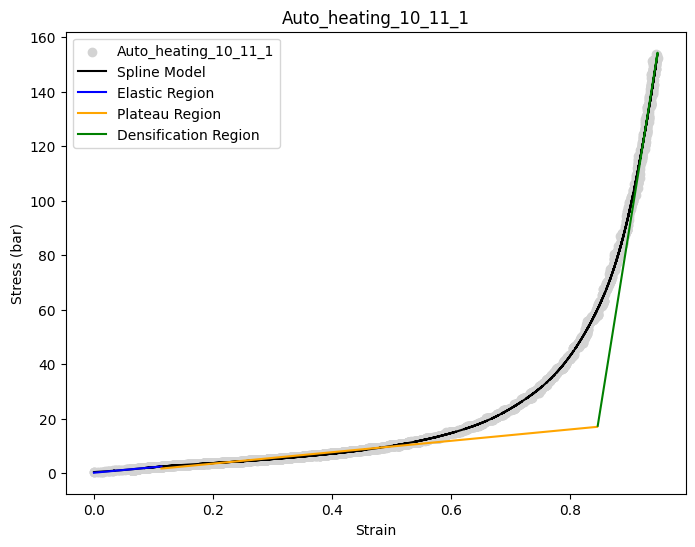

Good Fit: True


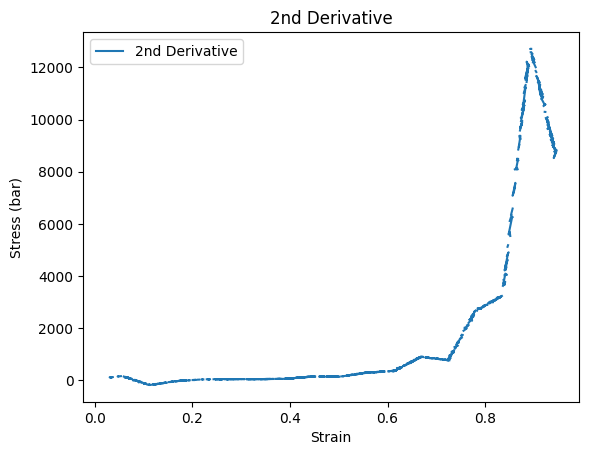

10_11_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8755057580350352
Elastic Modulus: 22.01254787671758
Plateau Slope: 19.309995775199837


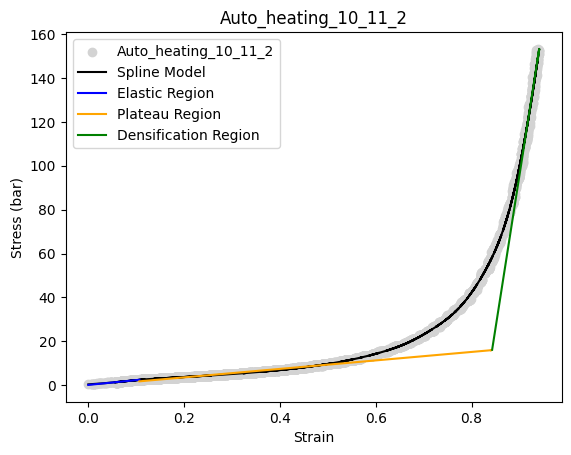

Good Fit: True


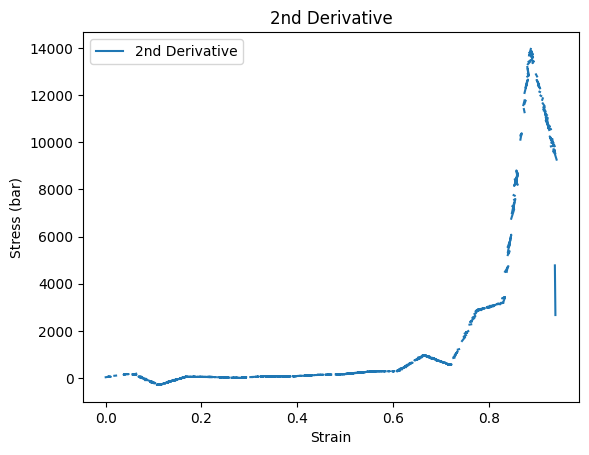

10_11_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8728027571903153
Elastic Modulus: 25.198608946885003
Plateau Slope: 19.603245586603347


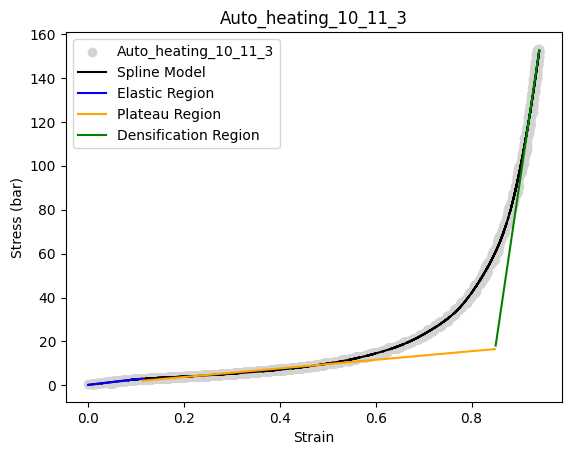

Good Fit: True


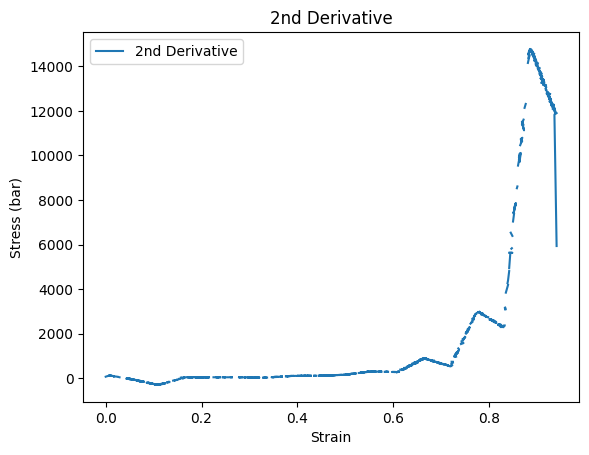

10_11_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8745862635647915
Elastic Modulus: 21.905809267285022
Plateau Slope: 19.3511520602224


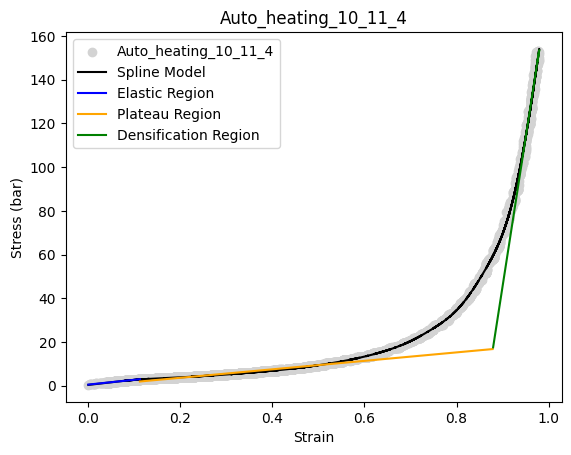

Good Fit: True


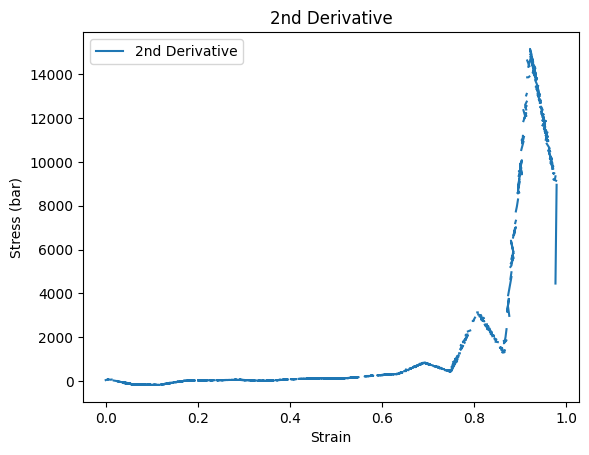

12_11_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9005052852385985
Elastic Modulus: 36.836979812367495
Plateau Slope: 28.838472554800443


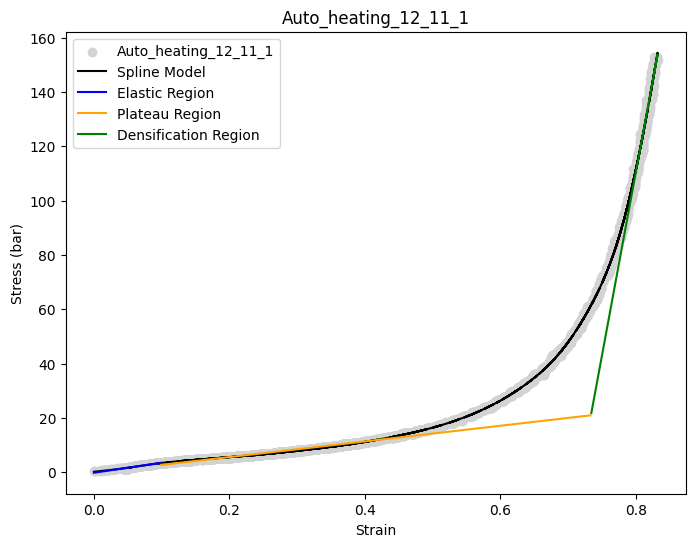

Good Fit: True


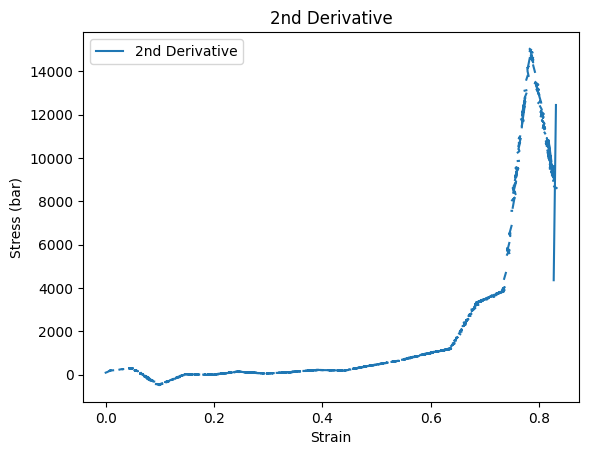

12_11_2


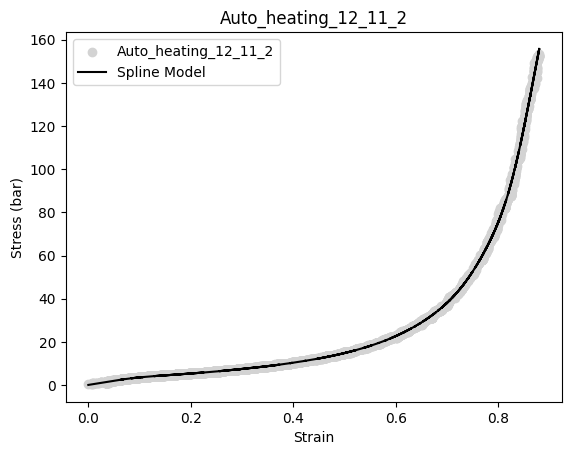

Good Fit: None


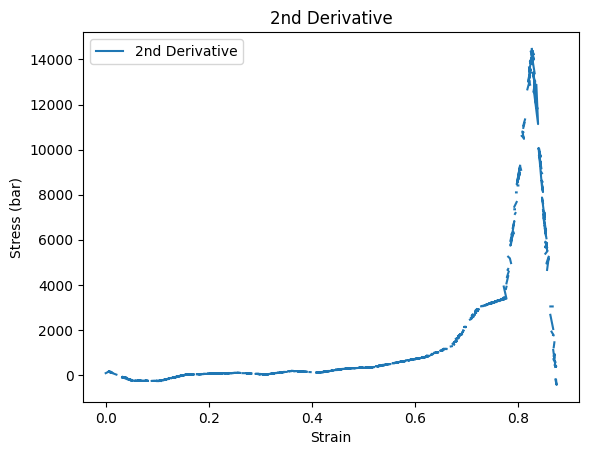

12_11_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9020869328171496
Elastic Modulus: 34.86898376037931
Plateau Slope: 27.44376020176786


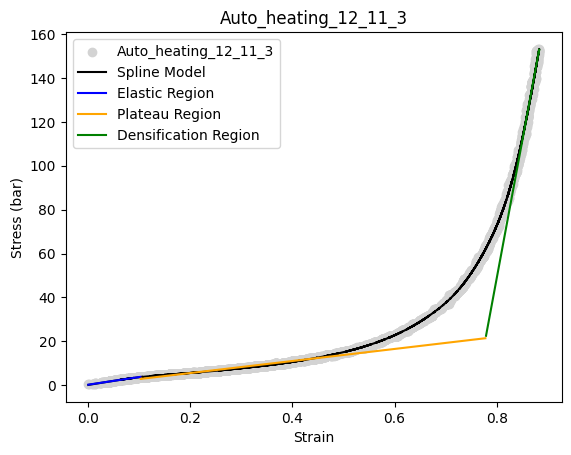

Good Fit: True


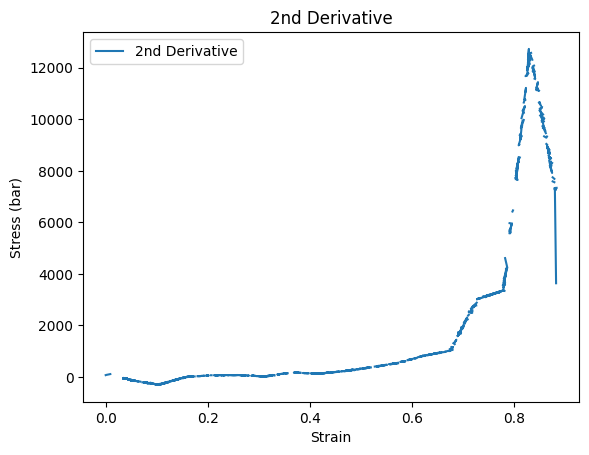

12_11_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9070701305632108
Elastic Modulus: 37.090758072126306
Plateau Slope: 28.65196702843924


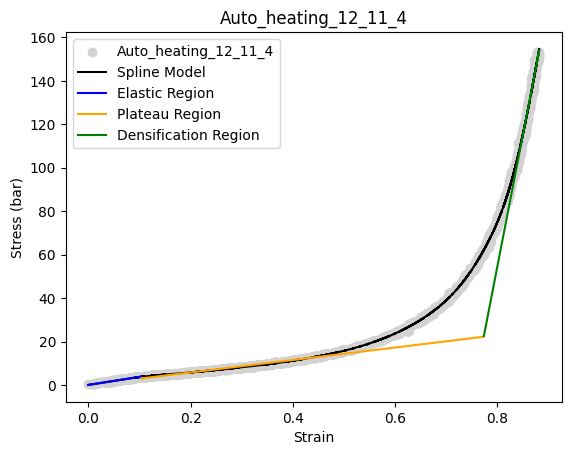

Good Fit: True


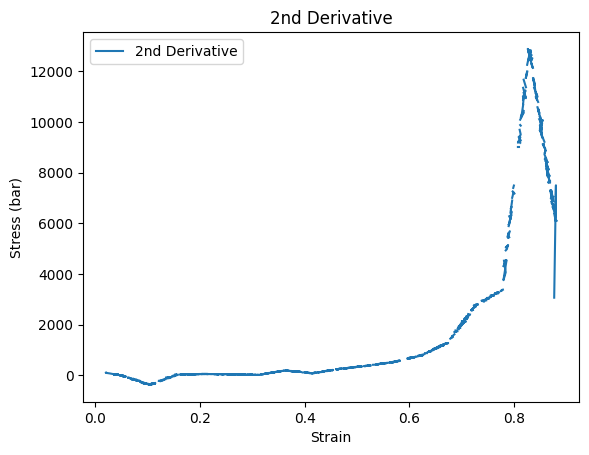

14_11_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9402806375714555
Elastic Modulus: 87.95079602388107
Plateau Slope: 43.85274069208432


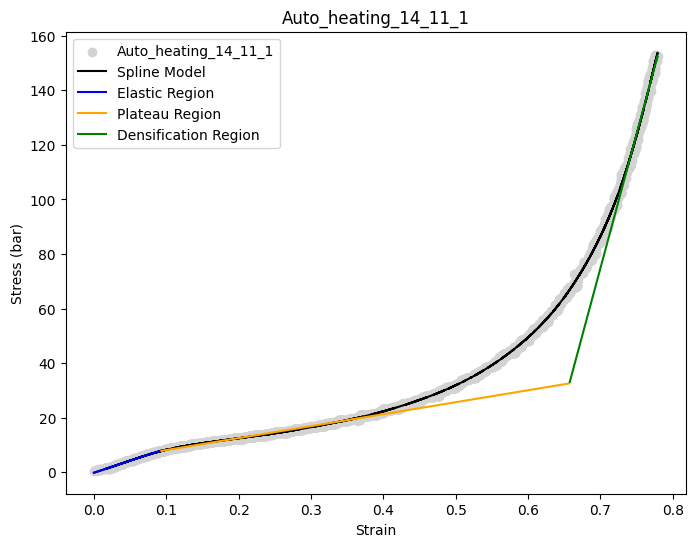

Good Fit: True


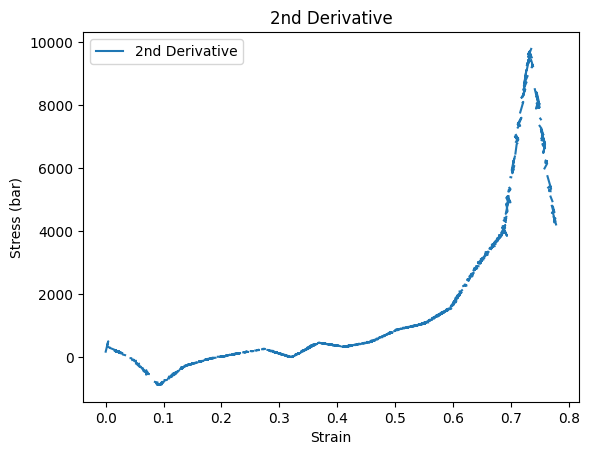

14_11_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9382035685632589
Elastic Modulus: 82.3661979329033
Plateau Slope: 41.45672735537539


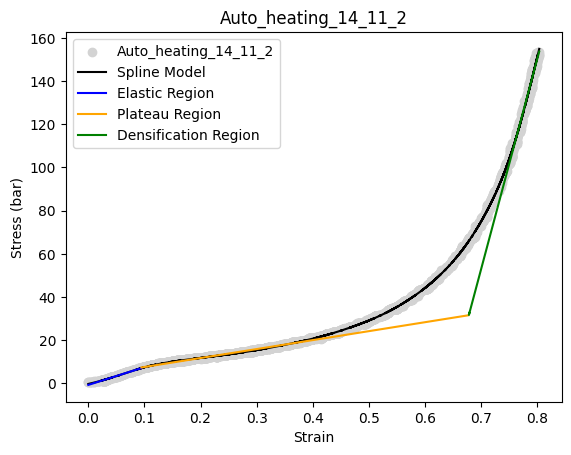

Good Fit: True


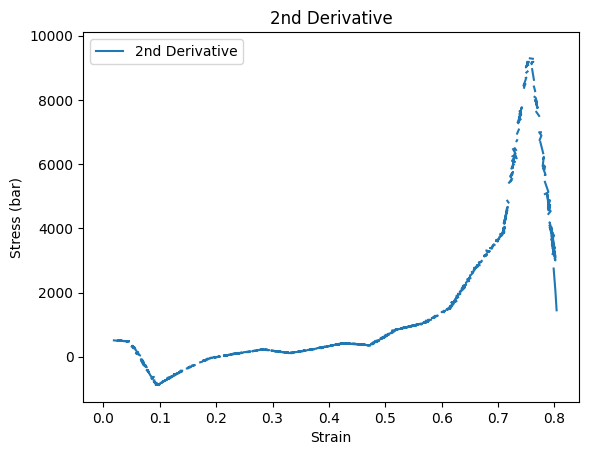

14_11_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9406417402306324
Elastic Modulus: 83.94906235836416
Plateau Slope: 43.148755082105545


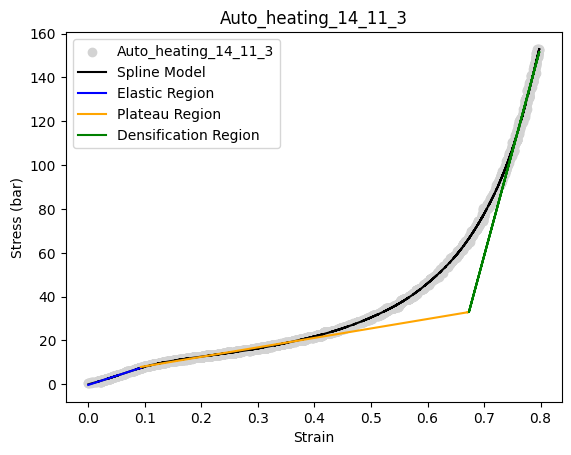

Good Fit: True


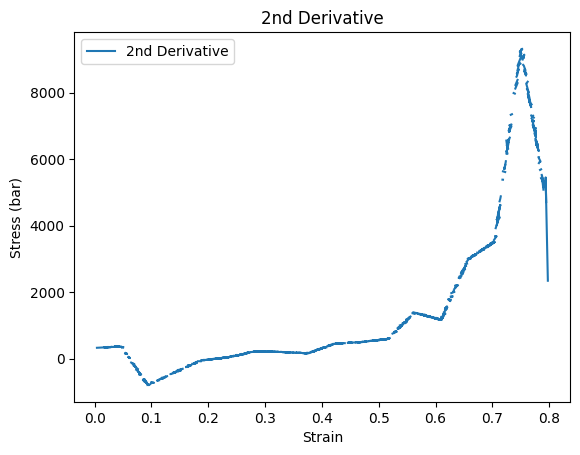

14_11_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9429066979697034
Elastic Modulus: 95.95424981989515
Plateau Slope: 45.195425422263575


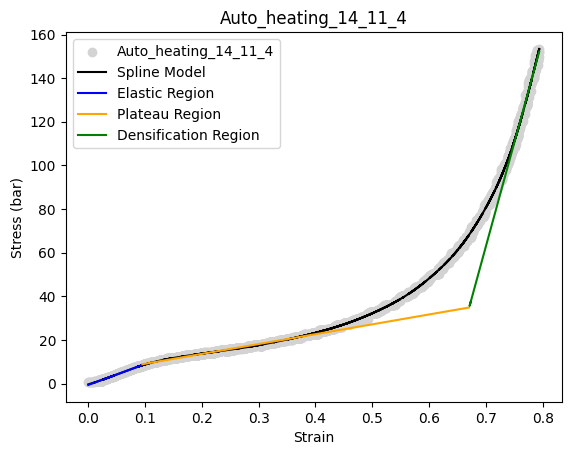

Good Fit: True


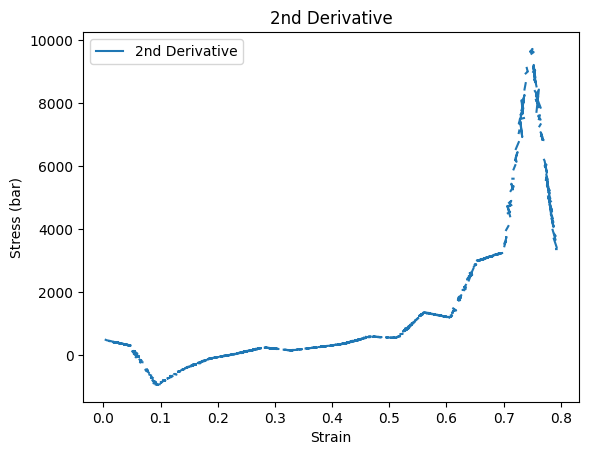

16_11_1
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9552303336103821
Elastic Modulus: 158.9632555180446
Plateau Slope: 59.96179704027712


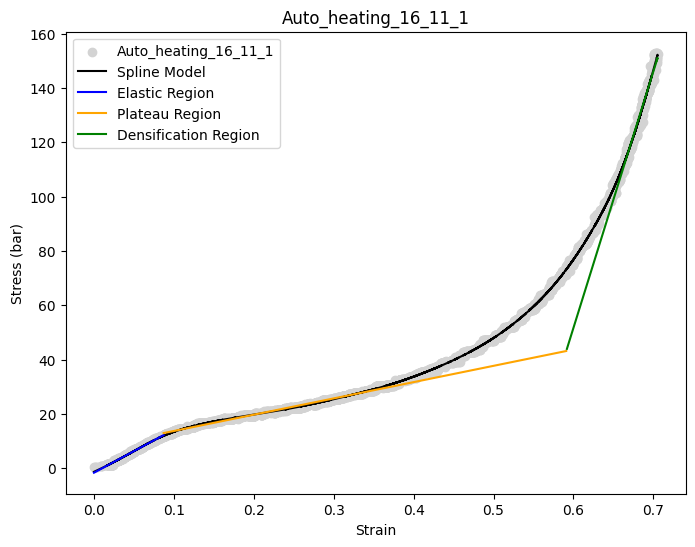

Good Fit: True


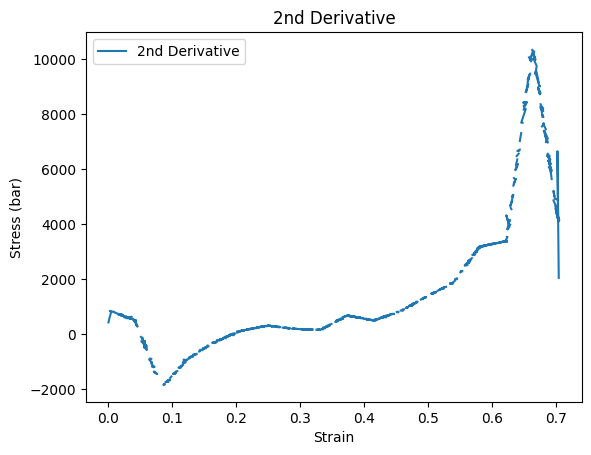

16_11_2
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9537042557190074
Elastic Modulus: 161.151069736347
Plateau Slope: 61.09372190022128


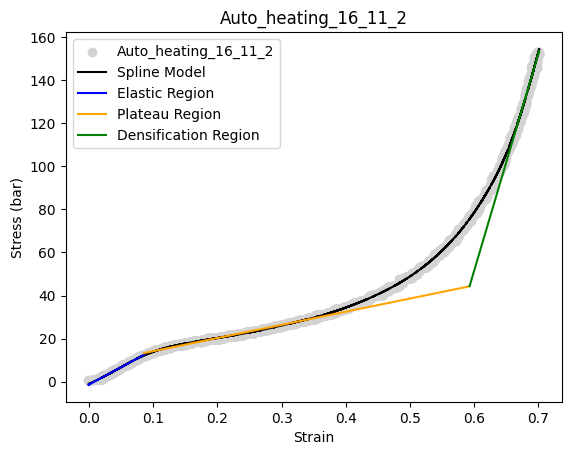

Good Fit: True


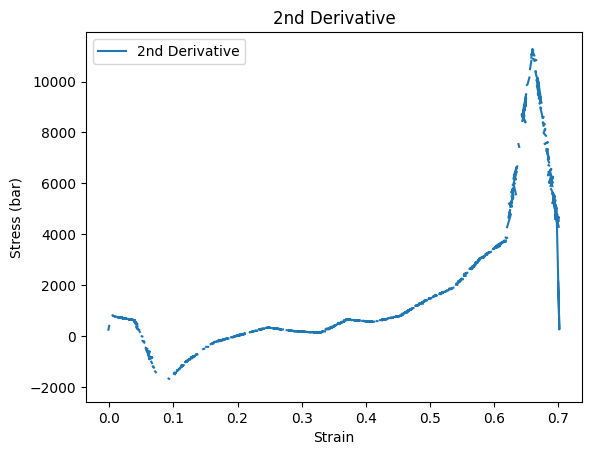

16_11_3
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.9519153524917993
Elastic Modulus: 162.53424065605859
Plateau Slope: 60.980737795650676


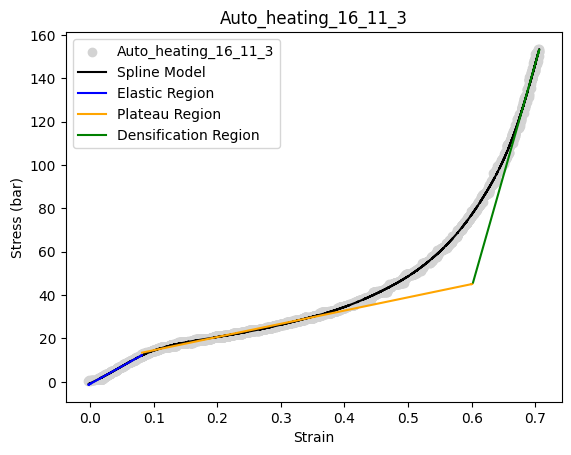

Good Fit: True


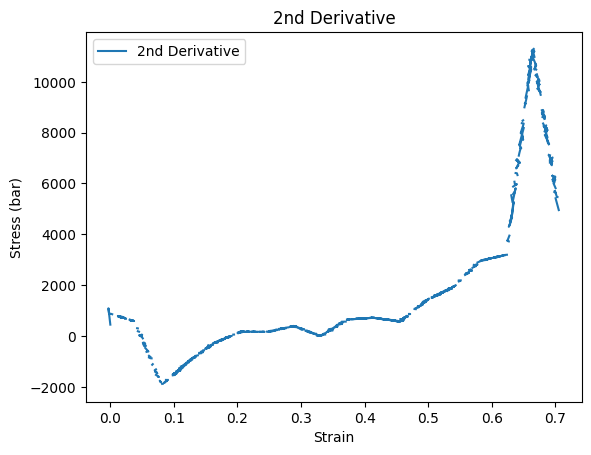

16_11_4
Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.953582631743988
Elastic Modulus: 166.25048773660532
Plateau Slope: 60.50973101703477


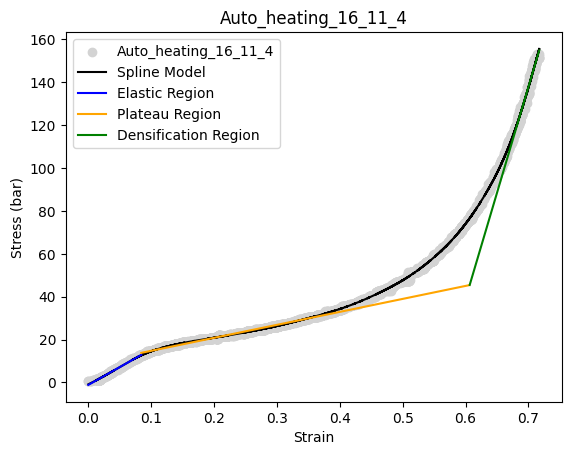

Good Fit: True


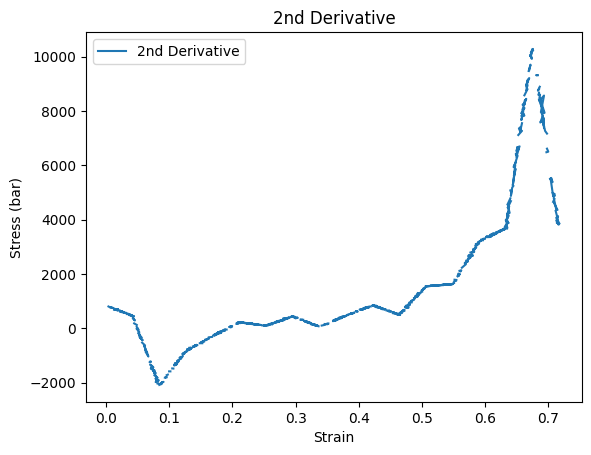

In [3]:
#extractAverage function lists
E_mean = []
E_stdev = []
YS_mean = []
YS_stdev = []
SP_mean = []
SP_stdev = []
SD_mean = []
SD_stdev = []
C_mean = []
C_stdev = []
conc = []
fit = []
heating = []
thickness_mean = []
thickness_stdev = []

#extract function lists
thickness = []
elasticModulus = []
yieldStrength = []
slopePlateau = []
slopeDensification = []
changepoint = []
fit = []
conc = []
heating = []
trial_number = []


#ALL DATA
#compression 4
Auto_noheating_10wt_4_1 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-1-240223_02232024_161809.csv')
Auto_noheating_10wt_4_2 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-2-240223_02232024_162119.csv')
Auto_noheating_10wt_4_3 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-3-240223_02232024_162456.csv')

data_list_10_4 = [Auto_noheating_10wt_4_1, Auto_noheating_10wt_4_2, Auto_noheating_10wt_4_3]
thickness_10_4 = [105,105,105]
properties_10_4 = interpretData(data_list_10_4, thickness_info = True, thickness_list = thickness_10_4, concentration_info = True, concentration = 9.99)
extract(properties_10_4)


Auto_noheating_12wt_4_1 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-1-240223_02232024_163339.csv')
Auto_noheating_12wt_4_2 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-2-240223_02232024_163631.csv')
Auto_noheating_12wt_4_3 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-3-240223_02232024_163935.csv')
Auto_noheating_12wt_4_4 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-4-240223_02232024_164316.csv')
Auto_noheating_12wt_4_5 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-5-240223_02232024_164618.csv')

data_list_12_4 = [Auto_noheating_12wt_4_1, Auto_noheating_12wt_4_2, Auto_noheating_12wt_4_3, Auto_noheating_12wt_4_4, Auto_noheating_12wt_4_5]
thickness_12_4 = [111,108,104,104,102]
properties_12_4 = interpretData(data_list_12_4, thickness_info = True, thickness_list = thickness_12_4, concentration_info = True, concentration = 11.63)
extract(properties_12_4)


Auto_noheating_15wt_4_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-1-240226_02262024_162514.csv')
Auto_noheating_15wt_4_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-2-240226_02262024_162808.csv')
Auto_noheating_15wt_4_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-3-240226_02262024_163110.csv')
Auto_noheating_15wt_4_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-4-240226_02262024_163353.csv')

data_list_15_4 = [Auto_noheating_15wt_4_1, Auto_noheating_15wt_4_2, Auto_noheating_15wt_4_3, Auto_noheating_15wt_4_4]
thickness_15_4 = [109,103,100,100]
properties_15_4 = interpretData(data_list_15_4, thickness_info = True, thickness_list = thickness_15_4, concentration_info = True, concentration = 14.43)
extract(properties_15_4)


Auto_noheating_17wt_4_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-1-240226_02262024_163853.csv')
Auto_noheating_17wt_4_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-2-240226_02262024_164117.csv')
Auto_noheating_17wt_4_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-3-240226_02262024_164351.csv')
Auto_noheating_17wt_4_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-4-240226_02262024_164621.csv')

data_list_17_4 = [Auto_noheating_17wt_4_1, Auto_noheating_17wt_4_2, Auto_noheating_17wt_4_3, Auto_noheating_17wt_4_4]
thickness_17_4 = [109,106,106,105]
properties_17_4 = interpretData(data_list_17_4, thickness_info = True, thickness_list = thickness_17_4, concentration_info = True, concentration = 17)
extract(properties_17_4)


#compression 5
Auto_noheating_10wt_5_1 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-1-240223_02232024_193040.csv')     #WEIRD FIT
Auto_noheating_10wt_5_2 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-2-240223_02232024_193342.csv')     #WEIRD FIT
Auto_noheating_10wt_5_3 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-3-240223_02232024_193652.csv')     #WEIRD FIT
Auto_noheating_10wt_5_4 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-4-240223_02232024_193947.csv')     #WEIRD FIT

data_list_10_5 = [Auto_noheating_10wt_5_1, Auto_noheating_10wt_5_2, Auto_noheating_10wt_5_3, Auto_noheating_10wt_5_4]
thickness_10_5 = [117,142,149,118]
properties_10_5 = interpretData(data_list_10_5, thickness_info = True, thickness_list = thickness_10_5, concentration_info = True, concentration = 9.99)
extract(properties_10_5)


Auto_noheating_17wt_5_1 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-1-240223_02232024_194527.csv')
Auto_noheating_17wt_5_2 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-2-240223_02232024_194752.csv')
Auto_noheating_17wt_5_3 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-3-240223_02232024_195016.csv')
Auto_noheating_17wt_5_4 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-4-240223_02232024_195303.csv')

data_list_17_5 = [Auto_noheating_17wt_5_1, Auto_noheating_17wt_5_2, Auto_noheating_17wt_5_3, Auto_noheating_17wt_5_4]
thickness_17_5 = [107,106,101,100]
properties_17_5 = interpretData(data_list_17_5, thickness_info = True, thickness_list = thickness_17_5, concentration_info = False)
extract(properties_17_5)


#compression 6
Auto_noheating_10wt_6_day1_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-1-240228_02282024_201331.csv')     #WEIRD FIT
Auto_noheating_10wt_6_day1_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-2-240228_02282024_201646.csv')     #WEIRD FIT
Auto_noheating_10wt_6_day1_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-3-240228_02282024_201943.csv')
Auto_noheating_10wt_6_day1_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-4-240228_02282024_202246.csv')

data_list_10_6_day1 = [Auto_noheating_10wt_6_day1_1, Auto_noheating_10wt_6_day1_2, Auto_noheating_10wt_6_day1_3, Auto_noheating_10wt_6_day1_4]
thickness_10_6_day1 = [99, 86, 98, 120]
properties_10_6_1 = interpretData(data_list_10_6_day1, thickness_info = True, thickness_list = thickness_10_6_day1, concentration_info = True, concentration = 9.99)
extract(properties_10_6_1)


Auto_noheating_10wt_6_day2_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-1-240229_02292024_165802.csv')
Auto_noheating_10wt_6_day2_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-2-240229_02292024_170133.csv')
Auto_noheating_10wt_6_day2_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-3-240229_02292024_170353.csv')
Auto_noheating_10wt_6_day2_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-4-240229_02292024_170638.csv')
Auto_noheating_10wt_6_day2_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-5-240229_02292024_170950.csv')    

data_list_10_6_day2 = [Auto_noheating_10wt_6_day2_1, Auto_noheating_10wt_6_day2_2, Auto_noheating_10wt_6_day2_3, Auto_noheating_10wt_6_day2_4, Auto_noheating_10wt_6_day2_5]
thickness_10_6_day2 = [76, 76, 62, 130, 156]
properties_10_6_2 = interpretData(data_list_10_6_day2, thickness_info = True, thickness_list = thickness_10_6_day2, concentration_info = True, concentration = 9.99)
extract(properties_10_6_2)


Auto_noheating_10wt_6_day3_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-1-240301_03012024_155023.csv')
Auto_noheating_10wt_6_day3_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-2-240301_03012024_155302.csv')
Auto_noheating_10wt_6_day3_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-3-240301_03012024_155535.csv')
Auto_noheating_10wt_6_day3_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-4-240301_03012024_155819.csv')
Auto_noheating_10wt_6_day3_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-5-240301_03012024_160114.csv')

data_list_10_6_day3 = [Auto_noheating_10wt_6_day3_1, Auto_noheating_10wt_6_day3_2, Auto_noheating_10wt_6_day3_3, Auto_noheating_10wt_6_day3_4, Auto_noheating_10wt_6_day3_5]
thickness_10_6_day3 = [74, 76, 121, 119, 113]
properties_10_6_3 = interpretData(data_list_10_6_day3, thickness_info = True, thickness_list = thickness_10_6_day3, concentration_info = True, concentration = 9.99)
extract(properties_10_6_3)


#compression 7
Auto_heating_12_7_1_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-1-240320_03202024_202947.csv')
Auto_heating_12_7_1_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-2-240320_03202024_203323.csv')
Auto_heating_12_7_1_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-3-240320_03202024_203606.csv')
Auto_heating_12_7_1_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-4-240320_03202024_203910.csv')

data_list_12_7_1 = [Auto_heating_12_7_1_1, Auto_heating_12_7_1_2, Auto_heating_12_7_1_3, Auto_heating_12_7_1_4]
thickness_12_7_1 = [115, 122, 125, 125]
properties_12_7_1 = interpretData(data_list_12_7_1, thickness_info = True, thickness_list = thickness_12_7_1, concentration_info = True, concentration = 11.63)
extract(properties_12_7_1)


Auto_heating_12_7_2_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-1-240320_03202024_204415.csv')
Auto_heating_12_7_2_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-2-240320_03202024_204706.csv')
Auto_heating_12_7_2_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-3-240320_03202024_204950.csv')
Auto_heating_12_7_2_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-4-240320_03202024_205221.csv')

data_list_12_7_2 = [Auto_heating_12_7_2_1, Auto_heating_12_7_2_2, Auto_heating_12_7_2_3, Auto_heating_12_7_2_4]
thickness_12_7_2 = [108,112,116,115]
properties_12_7_2 = interpretData(data_list_12_7_2, thickness_info = True, thickness_list = thickness_12_7_2, concentration_info = True, concentration = 11.63)
extract(properties_12_7_2)


#compression 8
Auto_heating_12_8_1 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-1-240328_03282024_152144.csv')
Auto_heating_12_8_2 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-2-240328_03282024_152416.csv')
Auto_heating_12_8_3 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-3-240328_03282024_152657.csv')
Auto_heating_12_8_4 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-4-240328_03282024_152944.csv')

data_list_12_8 = [Auto_heating_12_8_1, Auto_heating_12_8_2, Auto_heating_12_8_3, Auto_heating_12_8_4]
thickness_12_8 = [100,105,110,116]
properties_12_8 = interpretData(data_list_12_8, thickness_info = True, thickness_list = thickness_12_8, concentration_info = True, concentration = 11.63)
extract(properties_12_8)


Auto_heating_17_8_1 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-1-240328_03282024_153404.csv')
Auto_heating_17_8_2 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-2-240328_03282024_153634.csv')
Auto_heating_17_8_3 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-3-240328_03282024_153853.csv')
Auto_heating_17_8_4 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-4-240328_03282024_154142.csv')

data_list_17_8 = [Auto_heating_17_8_1, Auto_heating_17_8_2, Auto_heating_17_8_3, Auto_heating_17_8_4]
thickness_17_8 = [103,104,107,109]
properties_17_8 = interpretData(data_list_17_8, thickness_info = True, thickness_list = thickness_17_8, concentration_info = True, concentration = 17)
extract(properties_17_8)


#compression 9
Auto_heating_13_9_1 = pd.read_csv('Data/compression 9/AutoHeating-13-9-1--240404_04042024_173756.csv')
Auto_heating_13_9_2 = pd.read_csv('Data/compression 9/AutoHeating-13-9-2--240404_04042024_174116.csv')
Auto_heating_13_9_3 = pd.read_csv('Data/compression 9/AutoHeating-13-9-3--240404_04042024_174359.csv')  
Auto_heating_13_9_4 = pd.read_csv('Data/compression 9/AutoHeating-13-9-4--240404_04042024_174655.csv')

data_list_13_9 = [Auto_heating_13_9_1, Auto_heating_13_9_2, Auto_heating_13_9_3, Auto_heating_13_9_4]
thickness_13_9 = [112,121,125,137]
properties_13_9 = interpretData(data_list_13_9, thickness_info = True, thickness_list = thickness_13_9, concentration_info = True, concentration = 13)
extract(properties_13_9)


#compression 10
Auto_heating_17_10_1 = pd.read_csv('Data/compression 10/AutoHeating-17-10-1-240424_04242024_224404.csv')
Auto_heating_17_10_2 = pd.read_csv('Data/compression 10/AutoHeating-17-10-2-240424_04242024_224654.csv')
Auto_heating_17_10_3 = pd.read_csv('Data/compression 10/AutoHeating-17-10-3-240424_04242024_224921.csv')
Auto_heating_17_10_4 = pd.read_csv('Data/compression 10/AutoHeating-17-10-4-240424_04242024_225129.csv')
Auto_heating_17_10_5 = pd.read_csv('Data/compression 10/AutoHeating-17-10-5-240424_04242024_232454.csv')
Auto_heating_17_10_6 = pd.read_csv('Data/compression 10/AutoHeating-17-10-6-240424_04242024_232735.csv')
Auto_heating_17_10_7 = pd.read_csv('Data/compression 10/AutoHeating-17-10-7-240424_04242024_232950.csv')

data_list_17_10 = [Auto_heating_17_10_1, Auto_heating_17_10_2, Auto_heating_17_10_3, Auto_heating_17_10_4,
                   Auto_heating_17_10_5, Auto_heating_17_10_6, Auto_heating_17_10_7]
properties_17_10 = interpretData(data_list_17_10, thickness_info = False, concentration_info = False)
extract(properties_17_10)


#compression 11
Auto_heating_10_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_heating_10_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_heating_10_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_heating_10_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')

data_list_10_11 = [Auto_heating_10_11_1, Auto_heating_10_11_2, Auto_heating_10_11_3, Auto_heating_10_11_4]
properties_10_11 = interpretData(data_list_10_11, thickness_info = False, concentration_info = True, concentration = 10)
extract(properties_10_11)


Auto_heating_12_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-1-240530_05302024_161031.csv')
Auto_heating_12_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-2-240530_05302024_161322.csv')
Auto_heating_12_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-3-240530_05302024_161603.csv')
Auto_heating_12_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-4-240530_05302024_161848.csv')

data_list_12_11 = [Auto_heating_12_11_1, Auto_heating_12_11_2, Auto_heating_12_11_3, Auto_heating_12_11_4]
properties_12_11 = interpretData(data_list_12_11, thickness_info = False, concentration_info = True, concentration = 12)
extract(properties_12_11)


Auto_heating_14_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-1-240530_05302024_163014.csv')
Auto_heating_14_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-2-240530_05302024_163256.csv')
Auto_heating_14_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-3-240530_05302024_163547.csv')
Auto_heating_14_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-4-240530_05302024_163822.csv')

data_list_14_11 = [Auto_heating_14_11_1, Auto_heating_14_11_2, Auto_heating_14_11_3, Auto_heating_14_11_4]
properties_14_11 = interpretData(data_list_14_11, thickness_info = False, concentration_info = True, concentration = 14)
extract(properties_14_11)


Auto_heating_16_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-1-240530_05302024_172602.csv')
Auto_heating_16_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-2-240530_05302024_172818.csv')
Auto_heating_16_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-3-240530_05302024_173048.csv')
Auto_heating_16_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-4-240530_05302024_173310.csv')

data_list_16_11 = [Auto_heating_16_11_1, Auto_heating_16_11_2, Auto_heating_16_11_3, Auto_heating_16_11_4]
properties_16_11 = interpretData(data_list_16_11, thickness_info = False, concentration_info = True, concentration = 16)
extract(properties_16_11)

In [4]:
#for extract function

propertyData = {'Trial':trial_number,
                'Concentration':conc, 
                'Heating': heating,
                'Thickness': thickness,
                'Elastic Modulus': elasticModulus,
                'Yield Strength': yieldStrength,
                'Plateau Slope': slopePlateau,
                'Densification Slope': slopeDensification,
                'Changepoint': changepoint,
                'Fit':fit}

propertyData = pd.DataFrame(propertyData)
propertyData = propertyData.sort_values('Concentration')
propertyData.to_csv('property_data.csv', index=False)

    Concentration      E Mean    E Stdev  Yield Strength Mean  \
0            9.99   21.353755  16.376176             8.589551   
4            9.99   51.932395  30.188040            21.526897   
8            9.99   47.985386  29.972382             7.633992   
6            9.99   35.911225  18.845020            18.881557   
7            9.99   38.725873  39.906033            20.176823   
15          10.00   22.319251   2.099039             2.775848   
11          11.63   64.281217   4.058629            18.911344   
10          11.63   91.107997   9.365149            33.869510   
9           11.63   95.857146  10.510975            40.631616   
1           11.63   39.368196   7.398606             6.173426   
16          12.00   36.265574   1.216120             3.716842   
13          13.00   65.966729   7.736354            15.370020   
17          14.00   87.555077   6.072630             7.798534   
2           14.43  119.606618   3.298650             9.664296   
18          16.00  162.22

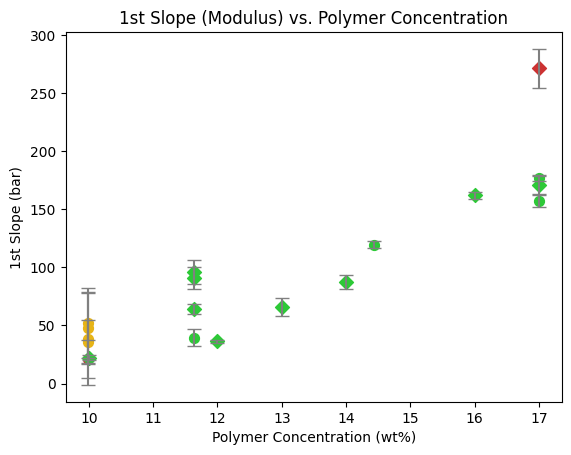

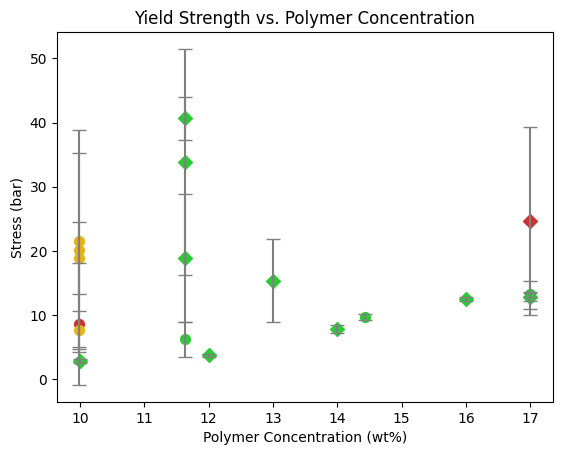

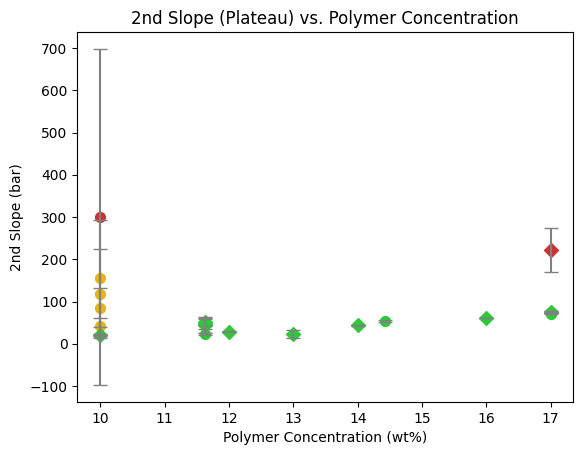

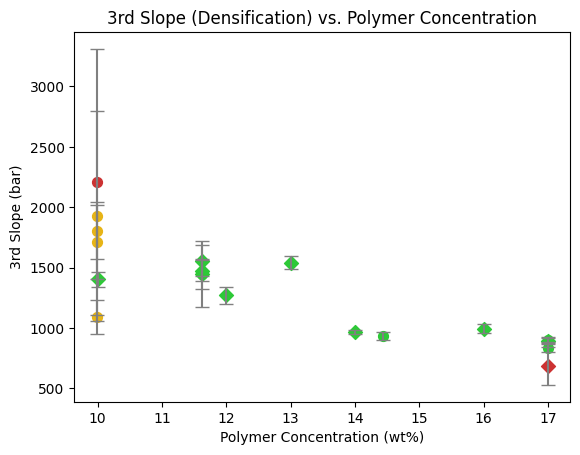

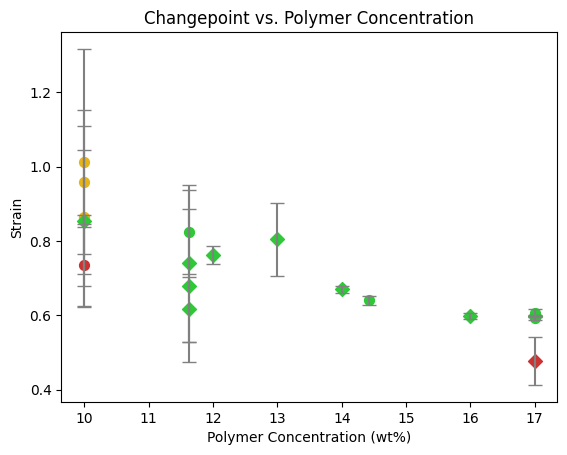

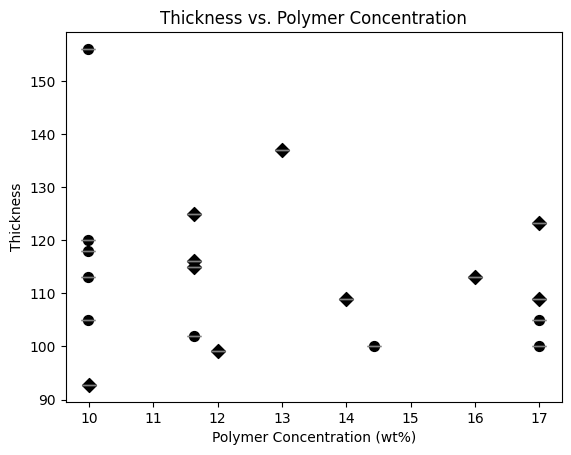

In [109]:
#for extractAverage function
propertyData = {'Concentration':conc, 
                'E Mean':E_mean, 'E Stdev':E_stdev, 
                'Yield Strength Mean':YS_mean, 'Yield Strength Stdev':YS_stdev,
                'Plateau Slope Mean':SP_mean, 'Plateau Slope Stdev':SP_stdev,
                'Densification Slope Mean':SD_mean, 'Densification Slope Stdev':SD_stdev,
                'Changepoint Mean':C_mean, 'Changepoint Stdev':C_stdev,
                'Thickness Mean': thickness_mean, 'Thickness Stdev': thickness_stdev,
                'Heating':heating,
                'Fit':fit}
                
propertyData = pd.DataFrame(propertyData)
propertyData = propertyData.sort_values('Concentration')
print(propertyData)

#COLOUR SORTING
color_map = {'GOOD': '#2dc937', 'OK': '#e7b416', 'BAD': '#cc3232'}
colors = [color_map[f] for f in propertyData['Fit']]
marker_map = {True:'D', False:'o'}
markers = [marker_map[f] for f in propertyData['Heating']]

#ELASTIC MODULUS PLOT
plt.errorbar(propertyData['Concentration'], propertyData['E Mean'], yerr=propertyData['E Stdev'], fmt='o', capsize=5, capthick=1, markersize=0, color='black' , ecolor='grey')
for x, y, c, m in zip(propertyData['Concentration'], propertyData['E Mean'], colors, markers):
    plt.scatter(x, y, color=c, s=50, edgecolor=c, marker=m)
plt.title("1st Slope (Modulus) vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("1st Slope (bar)")
plt.show()

#YIELD STRENGTH PLOT
plt.errorbar(propertyData['Concentration'], propertyData['Yield Strength Mean'], yerr=propertyData['Yield Strength Stdev'], fmt='o', capsize=5, capthick=1, markersize=0, color='black', ecolor='grey')
for x, y, c, m in zip(propertyData['Concentration'], propertyData['Yield Strength Mean'], colors, markers):
    plt.scatter(x, y, color=c, s=50, edgecolor=c, marker=m)
plt.title("Yield Strength vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("Stress (bar)")
plt.show()

#PLATEAU SLOPE PLOT
plt.errorbar(propertyData['Concentration'], propertyData['Plateau Slope Mean'], yerr=propertyData['Plateau Slope Stdev'], fmt='o', capsize=5, capthick=1, markersize=0, color='black', ecolor='grey')
for x, y, c, m in zip(propertyData['Concentration'], propertyData['Plateau Slope Mean'], colors, markers):
    plt.scatter(x, y, color=c, s=50, edgecolor=c, marker=m)
plt.title("2nd Slope (Plateau) vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("2nd Slope (bar)")
plt.show()

#DENSIFICATION SLOPE PLOT
plt.errorbar(propertyData['Concentration'], propertyData['Densification Slope Mean'], yerr=propertyData['Densification Slope Stdev'], fmt='o', capsize=5, capthick=1, markersize=0, color='black', ecolor='grey')
for x, y, c, m in zip(propertyData['Concentration'], propertyData['Densification Slope Mean'], colors, markers):
    plt.scatter(x, y, color=c, s=50, edgecolor=c, marker=m)
plt.title("3rd Slope (Densification) vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("3rd Slope (bar)")
plt.show()

#CHANGEPOINT PLOT
plt.errorbar(propertyData['Concentration'], propertyData['Changepoint Mean'], yerr=propertyData['Changepoint Stdev'], fmt='o', capsize=5, capthick=1, markersize=0, color='black', ecolor='grey')
for x, y, c, m in zip(propertyData['Concentration'], propertyData['Changepoint Mean'], colors, markers):
    plt.scatter(x, y, color=c, s=50, edgecolor=c, marker=m)
plt.title("Changepoint vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("Strain")
plt.show()

#THICKNESS PLOT
plt.errorbar(propertyData['Concentration'], propertyData['Thickness Mean'], yerr=propertyData['Thickness Stdev'], fmt='o', capsize=5, capthick=1, markersize=0, color='black', ecolor='grey')
for x, y, m in zip(propertyData['Concentration'], propertyData['Thickness Mean'], markers):
    plt.scatter(x, y, color='black', s=50, marker=m)
plt.title("Thickness vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("Thickness")
plt.show()

propertyData.to_csv('property_data.csv', index=False)

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8786826659622144
Elastic Modulus: 20.160039624559975
Plateau Slope: 20.880055741735102


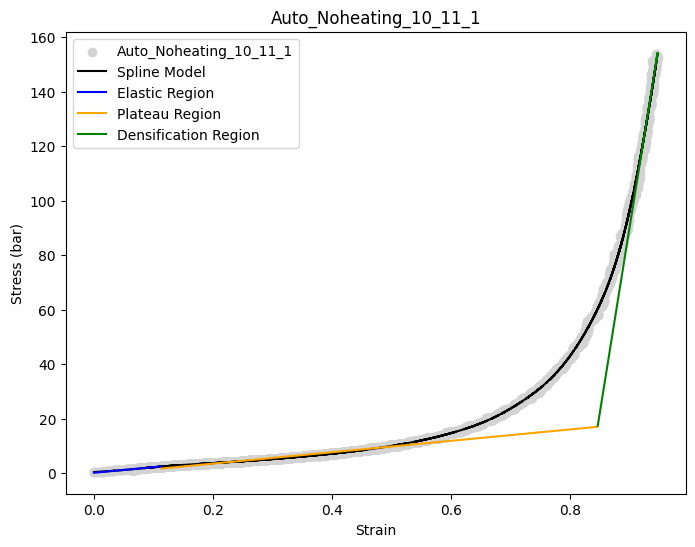

Good Fit: True


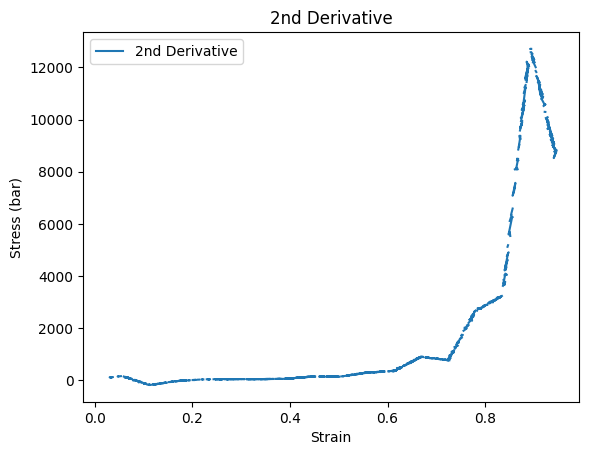

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8755057580350352
Elastic Modulus: 22.01254787671758
Plateau Slope: 19.309995775199837


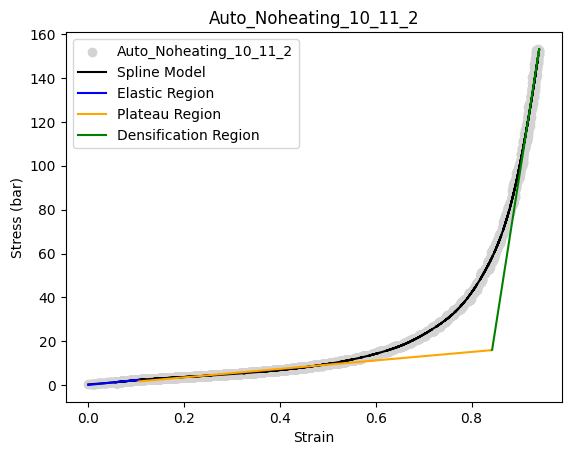

Good Fit: True


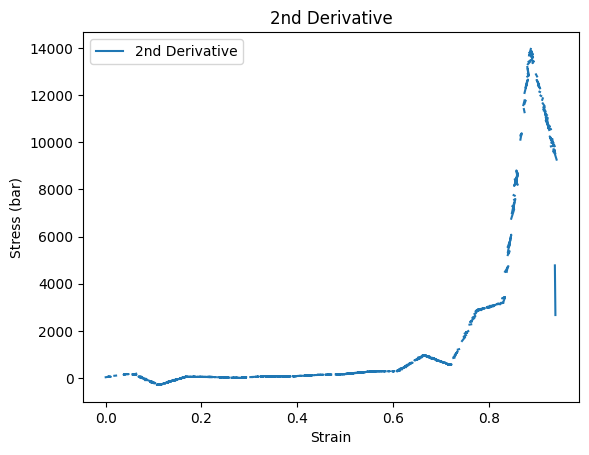

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8728027571903151
Elastic Modulus: 25.198608946885003
Plateau Slope: 19.73066847861


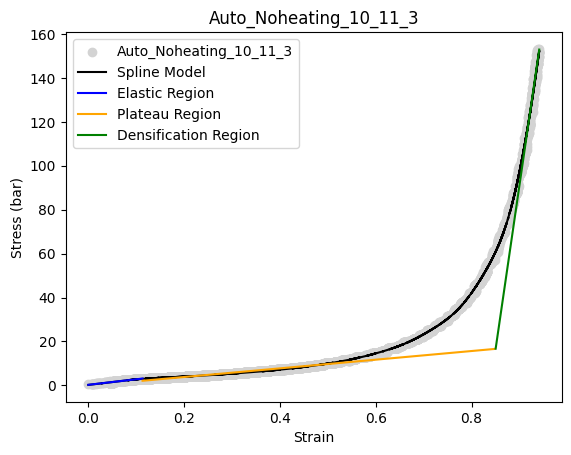

Good Fit: True


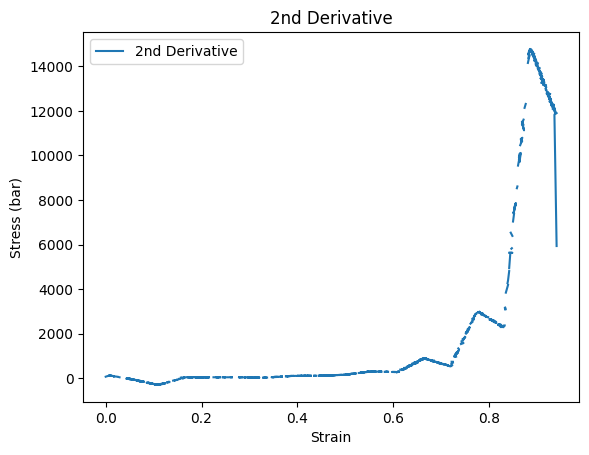

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8745862635647915
Elastic Modulus: 21.905809267285022
Plateau Slope: 19.3511520602224


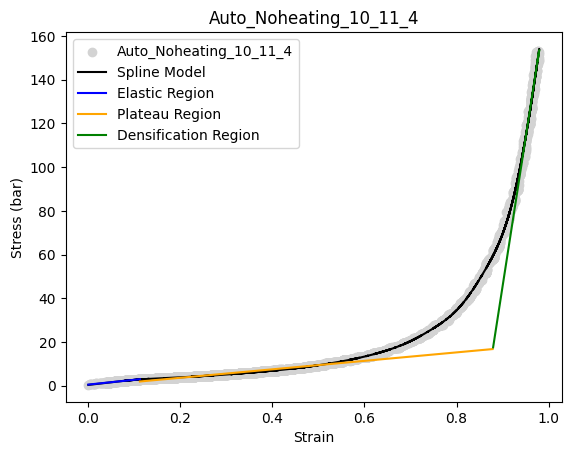

Good Fit: True


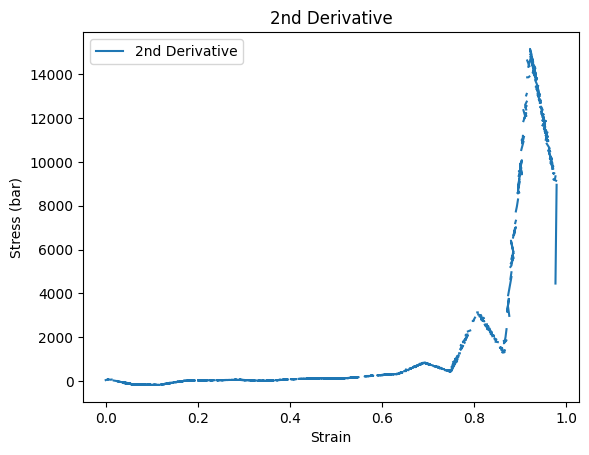

[None, False, {'Thickness': 94.615, 'Elastic Modulus': 20.160039624559975, 'Yield Strength': array([2.46611018]), 'Changepoint': 0.8469722040584169, 'Slope Plateau': 20.880055741735102, 'Slope Densification': 1359.1954053932661, 'Good Fit': True}, {'Thickness': 91.44, 'Elastic Modulus': 22.01254787671758, 'Yield Strength': array([2.52599997]), 'Changepoint': 0.8429338948860136, 'Slope Plateau': 19.309995775199837, 'Slope Densification': 1392.9490434782344, 'Good Fit': True}, {'Thickness': 94.9452, 'Elastic Modulus': 25.198608946885003, 'Yield Strength': array([3.10863303]), 'Changepoint': 0.8501255803151139, 'Slope Plateau': 19.73066847861, 'Slope Densification': 1497.0153967877366, 'Good Fit': True}, {'Thickness': 92.76079999999999, 'Elastic Modulus': 21.905809267285022, 'Yield Strength': array([3.00264825]), 'Changepoint': 0.8789465448426954, 'Slope Plateau': 19.3511520602224, 'Slope Densification': 1355.948498616825, 'Good Fit': True}]


[None,
 False,
 {'Thickness': 94.615,
  'Elastic Modulus': 20.160039624559975,
  'Yield Strength': array([2.46611018]),
  'Changepoint': 0.8469722040584169,
  'Slope Plateau': 20.880055741735102,
  'Slope Densification': 1359.1954053932661,
  'Good Fit': True},
 {'Thickness': 91.44,
  'Elastic Modulus': 22.01254787671758,
  'Yield Strength': array([2.52599997]),
  'Changepoint': 0.8429338948860136,
  'Slope Plateau': 19.309995775199837,
  'Slope Densification': 1392.9490434782344,
  'Good Fit': True},
 {'Thickness': 94.9452,
  'Elastic Modulus': 25.198608946885003,
  'Yield Strength': array([3.10863303]),
  'Changepoint': 0.8501255803151139,
  'Slope Plateau': 19.73066847861,
  'Slope Densification': 1497.0153967877366,
  'Good Fit': True},
 {'Thickness': 92.76079999999999,
  'Elastic Modulus': 21.905809267285022,
  'Yield Strength': array([3.00264825]),
  'Changepoint': 0.8789465448426954,
  'Slope Plateau': 19.3511520602224,
  'Slope Densification': 1355.948498616825,
  'Good Fit': T

In [79]:
#GOOD DATA
Auto_Noheating_10_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_Noheating_10_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_Noheating_10_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_Noheating_10_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')

data_list = [Auto_Noheating_10_11_1, Auto_Noheating_10_11_2, Auto_Noheating_10_11_3, Auto_Noheating_10_11_4]
interpretData(data_list, thickness_info = False)

In [ ]:
#BAD DATA
Auto_heating_17_10_1 = pd.read_csv('Data/compression 10/AutoHeating-17-10-1-240424_04242024_224404.csv')
Auto_heating_17_10_2 = pd.read_csv('Data/compression 10/AutoHeating-17-10-2-240424_04242024_224654.csv')
Auto_heating_17_10_3 = pd.read_csv('Data/compression 10/AutoHeating-17-10-3-240424_04242024_224921.csv')
Auto_heating_17_10_4 = pd.read_csv('Data/compression 10/AutoHeating-17-10-4-240424_04242024_225129.csv')
Auto_heating_17_10_5 = pd.read_csv('Data/compression 10/AutoHeating-17-10-5-240424_04242024_232454.csv')
Auto_heating_17_10_6 = pd.read_csv('Data/compression 10/AutoHeating-17-10-6-240424_04242024_232735.csv')
Auto_heating_17_10_7 = pd.read_csv('Data/compression 10/AutoHeating-17-10-7-240424_04242024_232950.csv')

data_list_17_10 = [Auto_heating_17_10_1, Auto_heating_17_10_2, Auto_heating_17_10_3, Auto_heating_17_10_4,
                   Auto_heating_17_10_5, Auto_heating_17_10_6, Auto_heating_17_10_7]
properties_17_10 = interpretData(data_list_17_10, thickness_info = False)